New functions for generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import cmath as cm
import math
import random
import scipy
from importlib import reload
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from multiprocess import *
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import plot, utils


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
%run -i ../../scripts/Images_generation/images_generator.py
%run -i ../../scripts/Images_generation/cosmos_generation.py

ERROR:root:File `'../../scripts/Images_generation/cosmos_generation.py'` not found.


5


In [4]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

# Test of recorded images

In [4]:
test = np.load('/sps/lsst/users/barcelin/data/isolated_galaxies/centered/test/galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [8]:
shifts = np.load('/sps/lsst/users/barcelin/data/single_galaxies/28/miscenter_19112019/test/galaxies_isolated_20191024_0_shifts.npy')

In [9]:
test.shape

(100, 2, 10, 64, 64)

In [19]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

In [11]:
input_noisy = test[:,0]
input_noiseless = test[:,1]

In [9]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [12]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

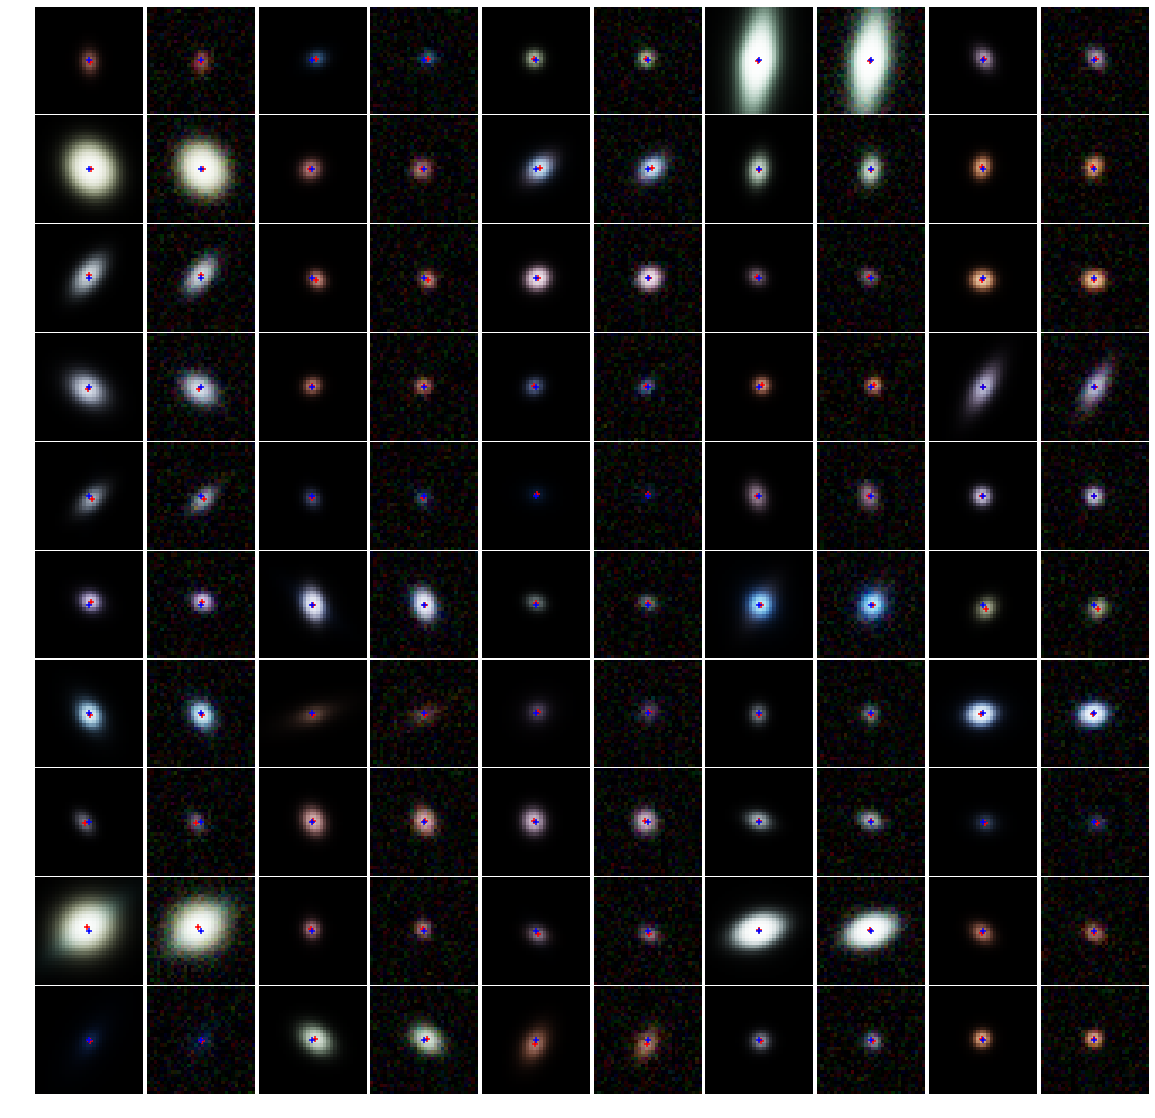

In [13]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [11]:
import astropy
import photutils

In [12]:
from photutils import find_peaks
from astropy.stats import sigma_clipped_stats

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

In [13]:
images = input_noiseless[:10000]

In [14]:
images = utils.denorm(images, bands,5, inplace = False)

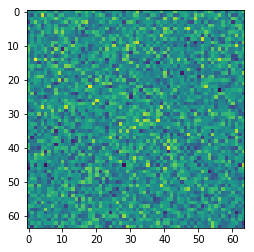

In [273]:
plt.imshow(images[241,6])

In [15]:
mean, median, std = sigma_clipped_stats(images[:,6], sigma=3.0)
threshold = np.sqrt(sky_level_pixel[6])

In [16]:
len(images)

10000

In [42]:
x_peaks = []
y_peaks = []
peaks_values = []

keys = ['idx','x_in','x_peak','x_peak_pix','y_in', 'y_peak','y_peak_pix', 'peak_value','r','r_closest']

df_peaks = pd.DataFrame(index = np.arange(len(images)), columns = keys)
indices = np.arange(len(images))

for i,idx in enumerate (indices):
    df_temp = find_peaks(images[i,6], threshold = median + 5.*std, npeaks = 4, box_size=3)#(median + 5.*std)
    if df_temp is not None:
        df_temp.sort('peak_value', reverse=True)
        r = [np.sqrt((shifts[idx][0,0]-(df_temp['x_peak'][0]-31.5)*0.2)**2+(shifts[idx][0,1]-(df_temp['y_peak'][0]-31.5)*0.2)**2)]
        df_peaks.loc[i] = [idx, shifts[idx][0,0], 
                           (df_temp['x_peak'][0]-31.5)*0.2,
                           df_temp['x_peak'][0],
                           shifts[idx][0,1], 
                           (df_temp['y_peak'][0]-31.5)*0.2,
                           df_temp['y_peak'][0],
                           df_temp['peak_value'][0],
                           r[0],
                           np.min(r)]
    
    else:
        df_peaks.loc[i] = [idx, shifts[idx][0,0], np.nan,np.nan, shifts[idx][0,1], np.nan, np.nan, np.nan, np.nan, np.nan]
df_peaks

idx        x_in x_peak x_peak_pix        y_in y_peak y_peak_pix  \
0        0   0.0153026    0.1         32    0.029538    0.1         32   
1        1   0.0580095    0.1         32  -0.0227557   -0.1         31   
2        2  0.00934518   -0.1         31   0.0372891   -0.1         31   
3        3   -0.053094   -0.1         31    0.096127    0.1         32   
4        4 -0.00675789   -0.1         31   0.0187574   -0.1         31   
5        5   0.0985849    0.1         32  -0.0595613   -0.1         31   
6        6   0.0397115    0.1         32   0.0479586    0.1         32   
7        7   0.0271958    0.7         35  0.00033582    0.1         32   
8        8   0.0842286    0.1         32  -0.0689269   -0.1         31   
9        9   0.0294273   -0.1         31 -0.00731303   -0.1         31   
10      10  -0.0828389   -0.1         31   0.0278153    0.1         32   
11      11   0.0131099    0.1         32  -0.0100356    0.1         32   
12      12  -0.0437274   -0.1         31   0.0705792    0.1         32   
13      13  0.00650493    0.1         32  -0.0646276   -0.1         31   
14      14  -0.0878971   -0.1         31   0.0652067    0.1         32   
15      15   -0.074166   -0.1         31   0.0771045    0.1         32   
16      16  0.00669467   -0.1         31   0.0775388    0.1         32   
17      17  -0.0902356   -0.1         31   0.0859537    0.1         32   
18      18  -0.0995819   -0.5         29  -0.0242047   -0.1         31   
19      19  -0.0717918   -0.1         31    0.040672    0.1         32   
20      20   0.0664862    0.1         32  -0.0209745   -0.1         31   
21      21  0.00457431    0.3         33   0.0902045    0.7         35   
22      22    0.017212    0.1         32   0.0453822    0.1         32   
23      23  -0.0722972   -0.3         30  -0.0866548   -1.5         24   
24      24   0.0236615    0.1         32   0.0586593    0.1         32   
25      25  -0.0935494   -0.1         31  -0.0649473   -0.1         31   
26      26  -0.0951611   -0.1         31  0.00247965   -0.1         31   
27      27   0.0949442    0.1         32  -0.0701923   -0.1         31   
28      28  -0.0686614   -0.1         31   0.0721299    0.1         32   
29      29  -0.0120558    0.1         32  -0.0659169    0.1         32   
...    ...         ...    ...        ...         ...    ...        ...   
9970  9970   0.0685768    0.1         32  -0.0687353   -0.1         31   
9971  9971  0.00225859   -0.1         31  -0.0296708   -0.1         31   
9972  9972  -0.0358015   -0.1         31   0.0979153    0.1         32   
9973  9973  -0.0328023   -0.7         28  -0.0372761   -0.1         31   
9974  9974   0.0965954    0.1         32   -0.033281   -0.1         31   
9975  9975  -0.0709735   -0.1         31   0.0354906    0.1         32   
9976  9976  -0.0289651   -0.1         31  -0.0210276   -0.1         31   
9977  9977     0.09848    0.5         34  -0.0563374   -0.1         31   
9978  9978  -0.0398147    0.1         32  -0.0156368    0.1         32   
9979  9979  -0.0732396   -0.1         31  0.00309727   -0.1         31   
9980  9980  -0.0417294   -0.1         31  -0.0329562    0.1         32   
9981  9981  0.00632471   -0.5         29  -0.0157852   -1.3         25   
9982  9982    0.038576    0.1         32  -0.0909716   -0.1         31   
9983  9983   0.0562554    0.1         32    0.081159    0.1         32   
9984  9984  -0.0248533   -0.1         31   0.0593834    0.1         32   
9985  9985   0.0514617    0.1         32  -0.0391476    0.1         32   
9986  9986   0.0860974    0.1         32  -0.0959669   -0.1         31   
9987  9987   0.0322103   -0.1         31  -0.0721167   -0.1         31   
9988  9988  -0.0796057   -0.1         31   0.0521334    0.1         32   
9989  9989  -0.0271316   -0.1         31   0.0505163    0.1         32   
9990  9990   0.0168019   -0.1         31   0.0673325    0.1         32   
9991  9991   0.0680607    0.1         32  -0.0976471   -0.1         31   
9992  9992 

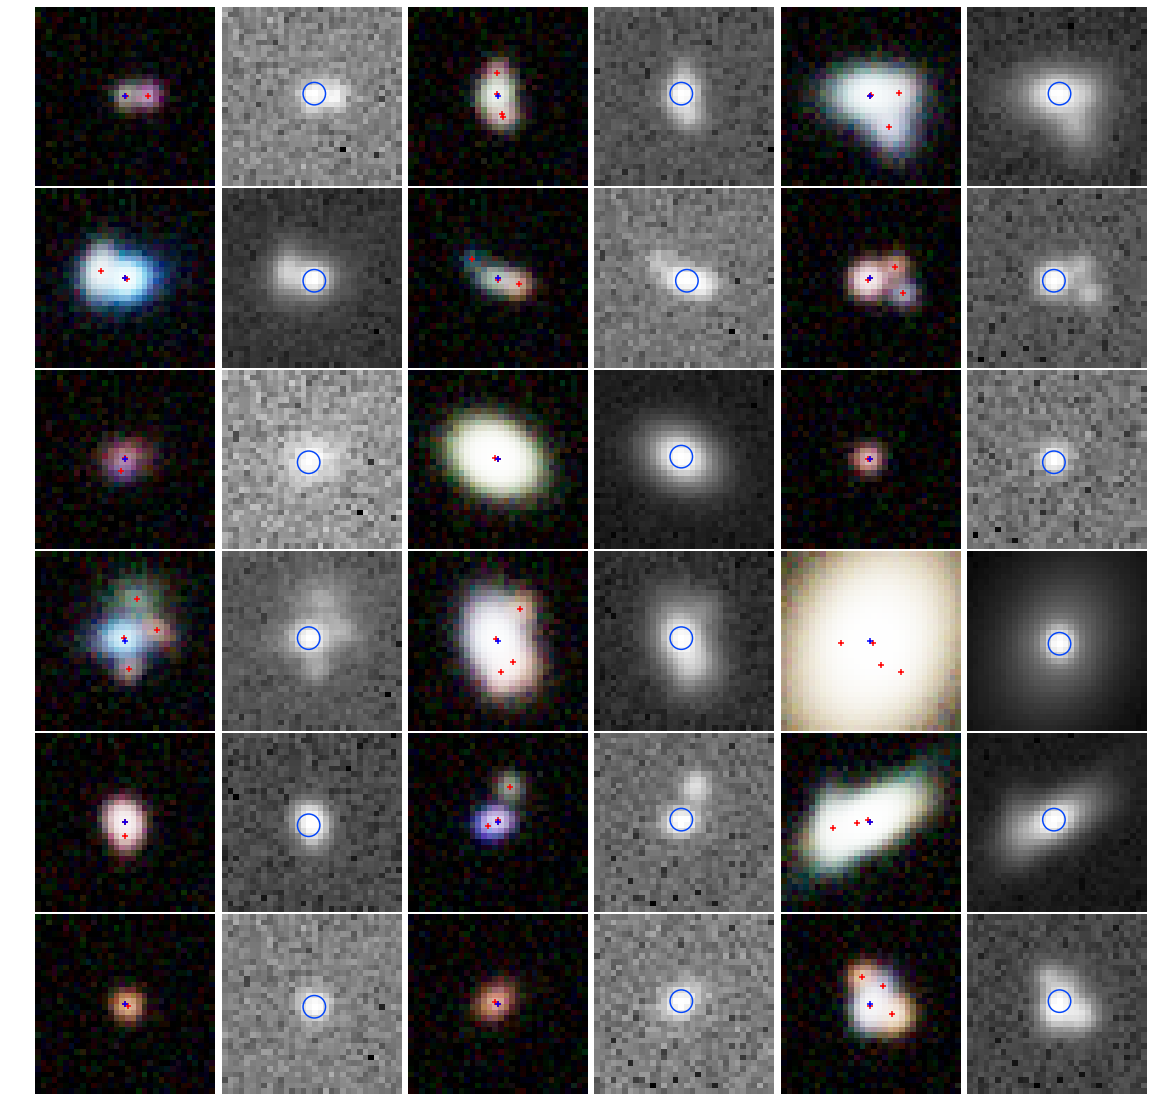

In [18]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.arange(100)#np.random.choice(50, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        
        
        positions = np.transpose((df_peaks['x_peak_pix'][i+j*N_plot]-16, df_peaks['y_peak_pix'][i+j*N_plot]-16))
        apertures = CircularAperture(positions, r=2.)
        norm = simple_norm(images[i+j*N_plot,6,16:48,16:48], 'sqrt', percent=99.9)#,16:48,16:48
        axes[i,j+1].imshow(images[i+j*N_plot,6,16:48,16:48], cmap='Greys_r', origin='lower', norm=norm)
        apertures.plot(color='#0547f9', lw=1.5, axes = axes[i,j+1])
        
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')


ValueError: color kwarg must have one color per data set. 9898 data sets and 1 colors were provided

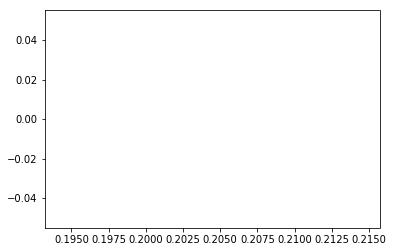

In [41]:
sns.distplot(df_peaks.dropna()['r'])

In [31]:
image_test = np.zeros((65,65))
image_test[32,32]= 2
image_test[31,32]= 1
image_test[32,31]= 5
image_test[31,31]= 4


In [32]:
import photutils

In [33]:
from photutils.centroids import centroid_com

gal = image_test

df_temp = photutils.find_peaks(gal, threshold=0, npeaks=4, centroid_func=centroid_com)


In [34]:
print(df_temp)

x_peak y_peak peak_value x_centroid     y_centroid    
------ ------ ---------- ---------- ------------------
    31     32        5.0      31.25 31.583333333333332


In [22]:
test = np.load('/sps/lsst/users/barcelin/data/blended_images/28/miscenter_19112019/test/galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [23]:
shifts = np.load('/sps/lsst/users/barcelin/data/blended_images/28/miscenter_19112019/test/galaxies_isolated_20191024_0_shifts.npy')

In [24]:
input_noisy = test[:,0]
input_noiseless = test[:,1]

In [25]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

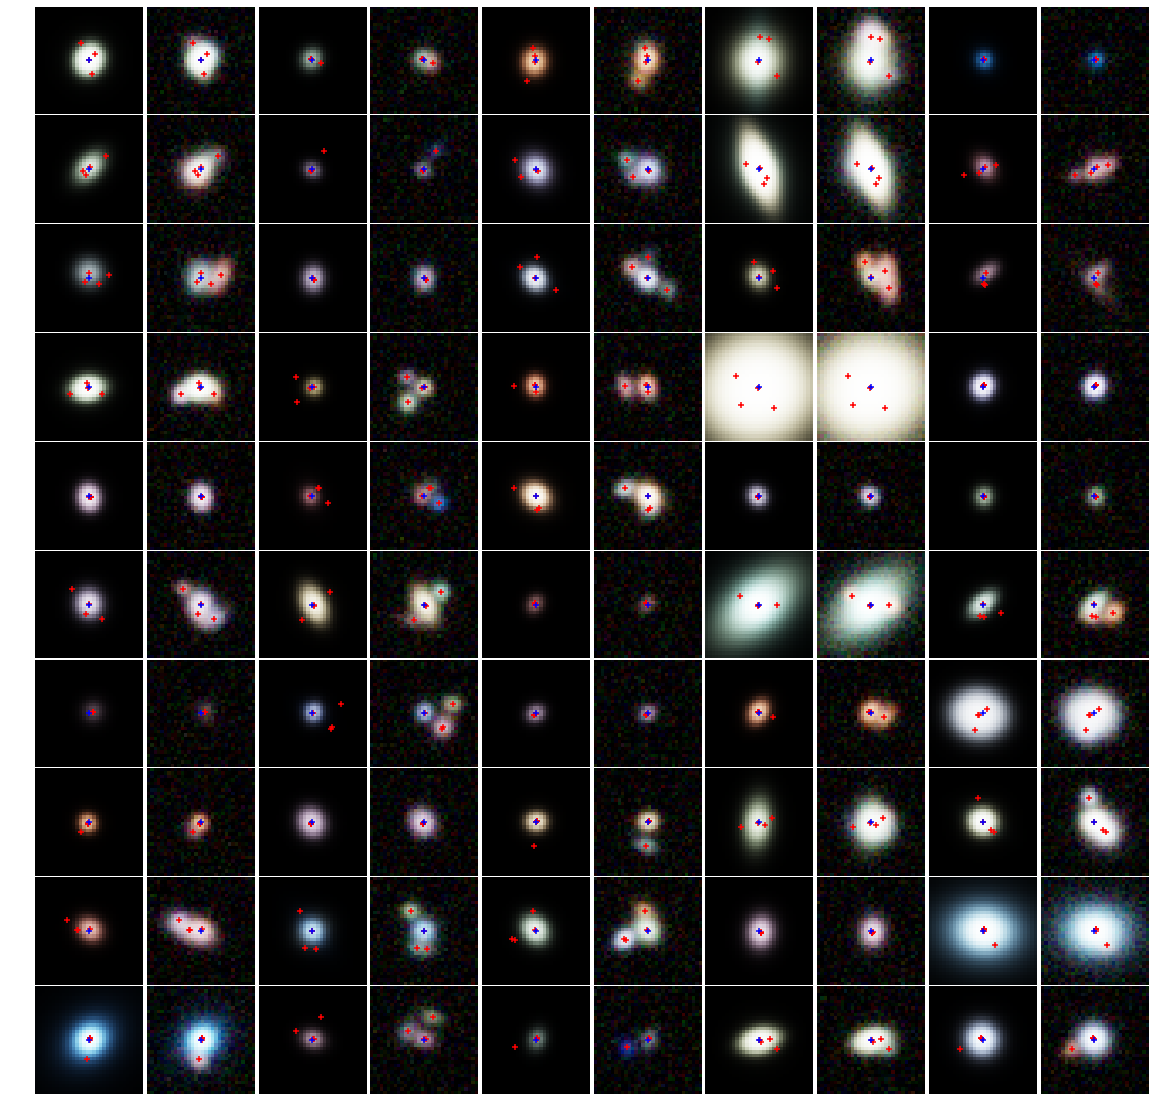

In [26]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [16]:
images = np.load('../../scripts/Images_generation/blended_images.py')

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [39]:
test = np.load('/sps/lsst/users/barcelin/data/single_galaxies/28/miscenter_19112019/training/galaxies_isolated_20191024_0_10_images.npy', mmap_mode = 'c')

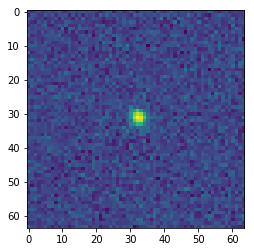

In [40]:
plt.imshow(test[0,1,6])

In [13]:
test = np.load('/sps/lsst/users/barcelin/data/isolated_galaxies/centered/validation/galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [14]:
input_noisy = test[:500,0]
input_noiseless = test[:500,1]

In [11]:
#input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
#input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

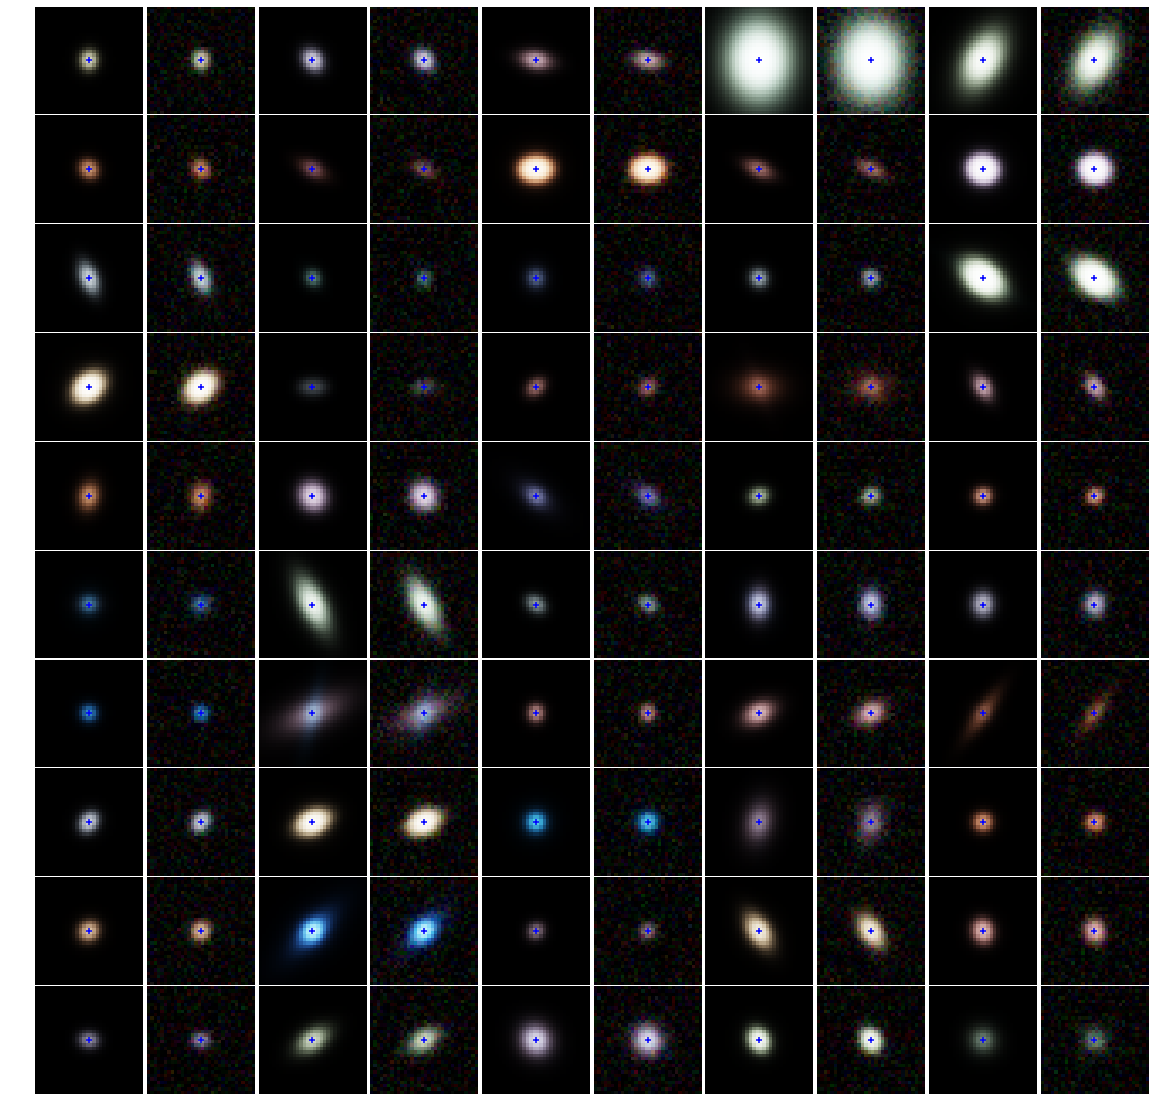

In [15]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [16]:
test = np.load('/sps/lsst/users/barcelin/data/isolated_galaxies/miscentered_0.1/validation/galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [17]:
input_noisy = test[:500,0]
input_noiseless = test[:500,1]

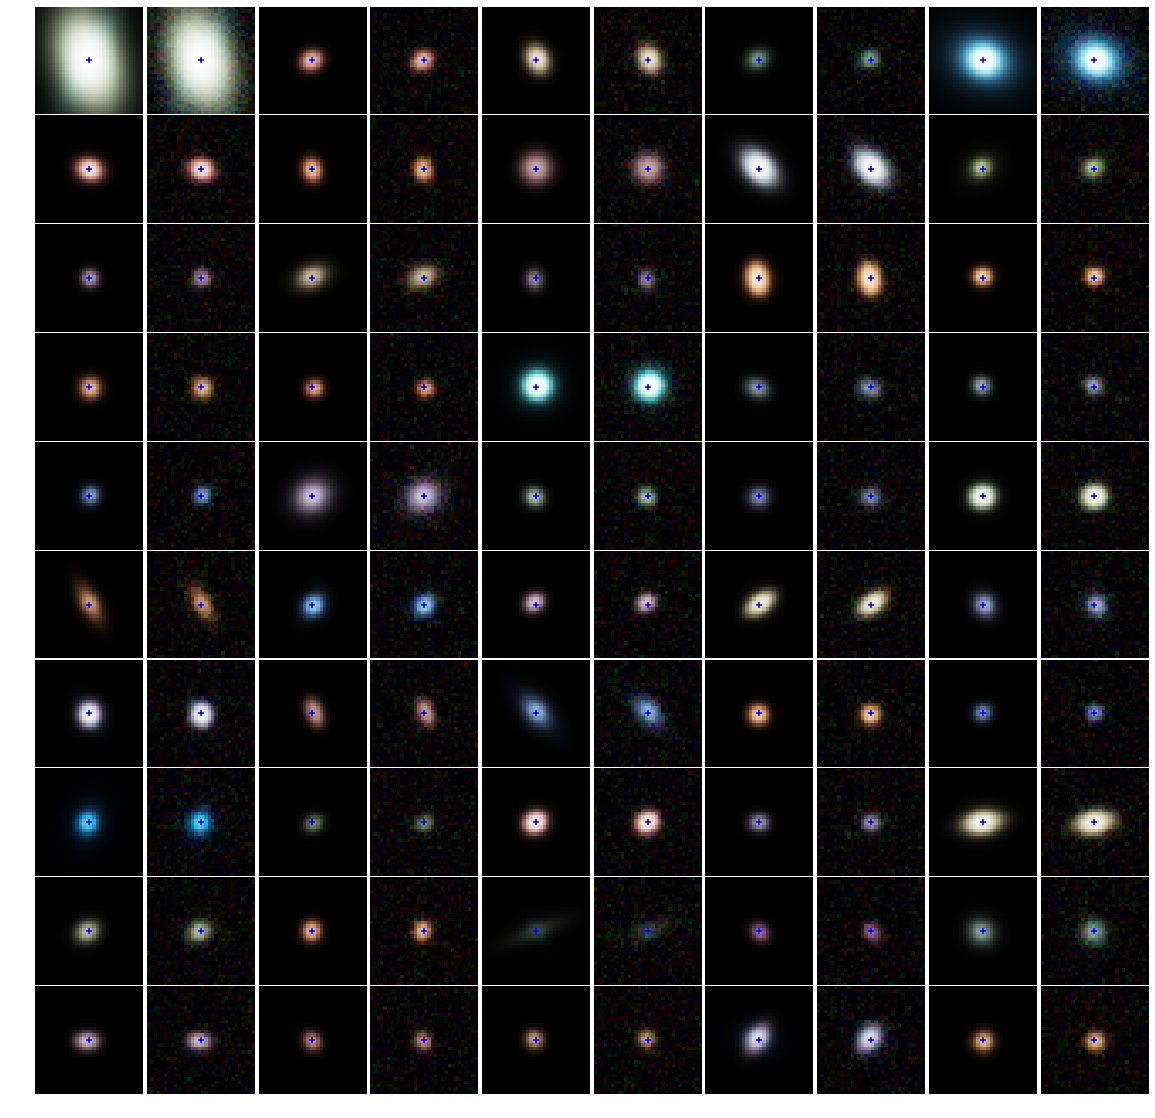

In [18]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [19]:
test = np.load('/sps/lsst/users/barcelin/data/isolated_galaxies/miscentered_peak/validation/galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [20]:
input_noisy = test[:500,0]
input_noiseless = test[:500,1]

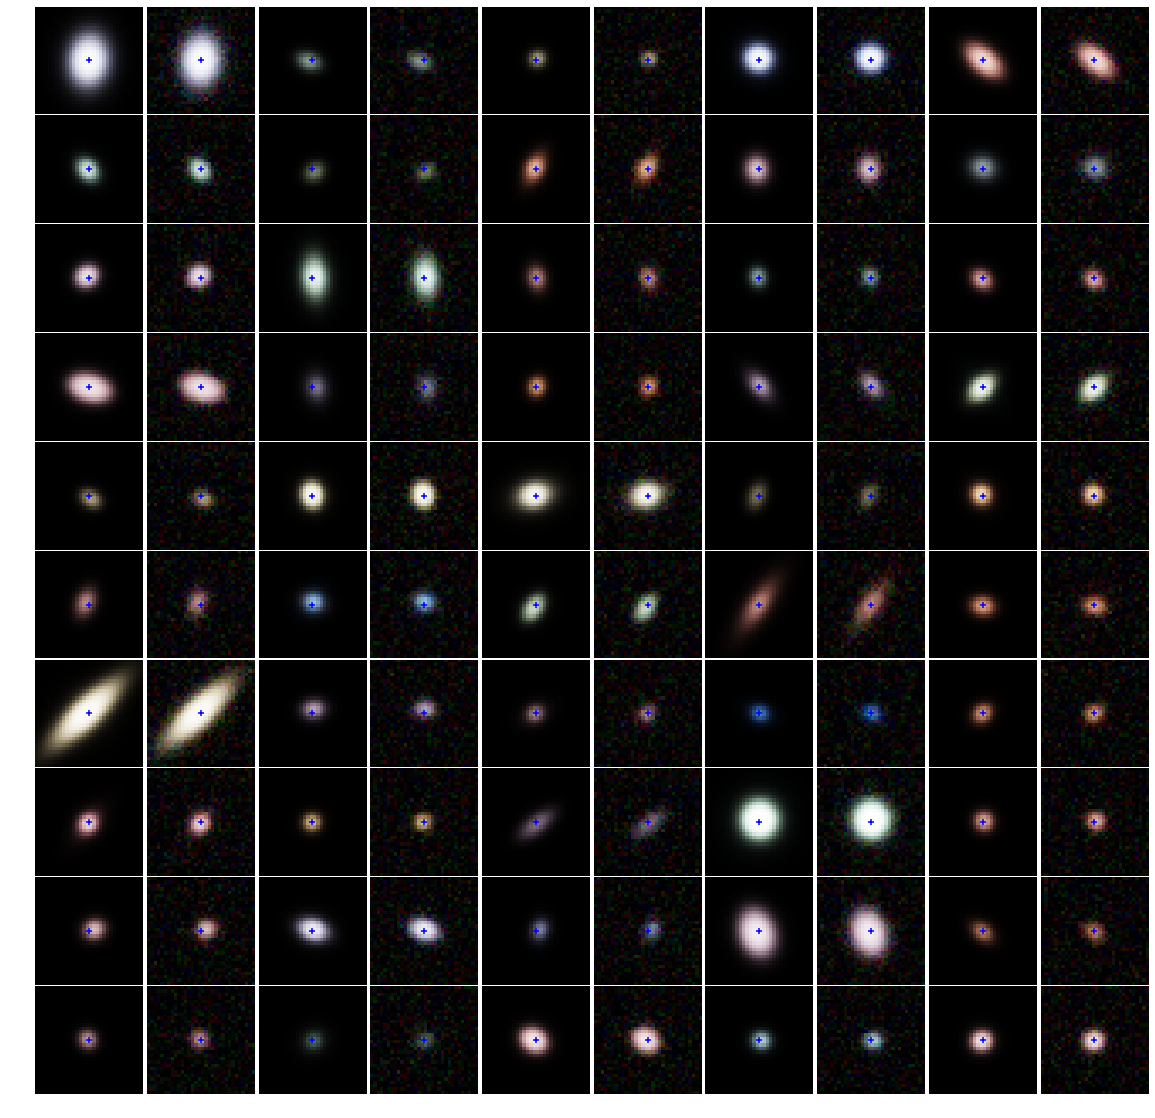

In [21]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [15]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/centered/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

In [16]:
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/centered/test/galaxies_blended_20191024_0_shifts.npy')

In [17]:
input_noisy = test[:500,0]
input_noiseless = test[:500,1]

In [20]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

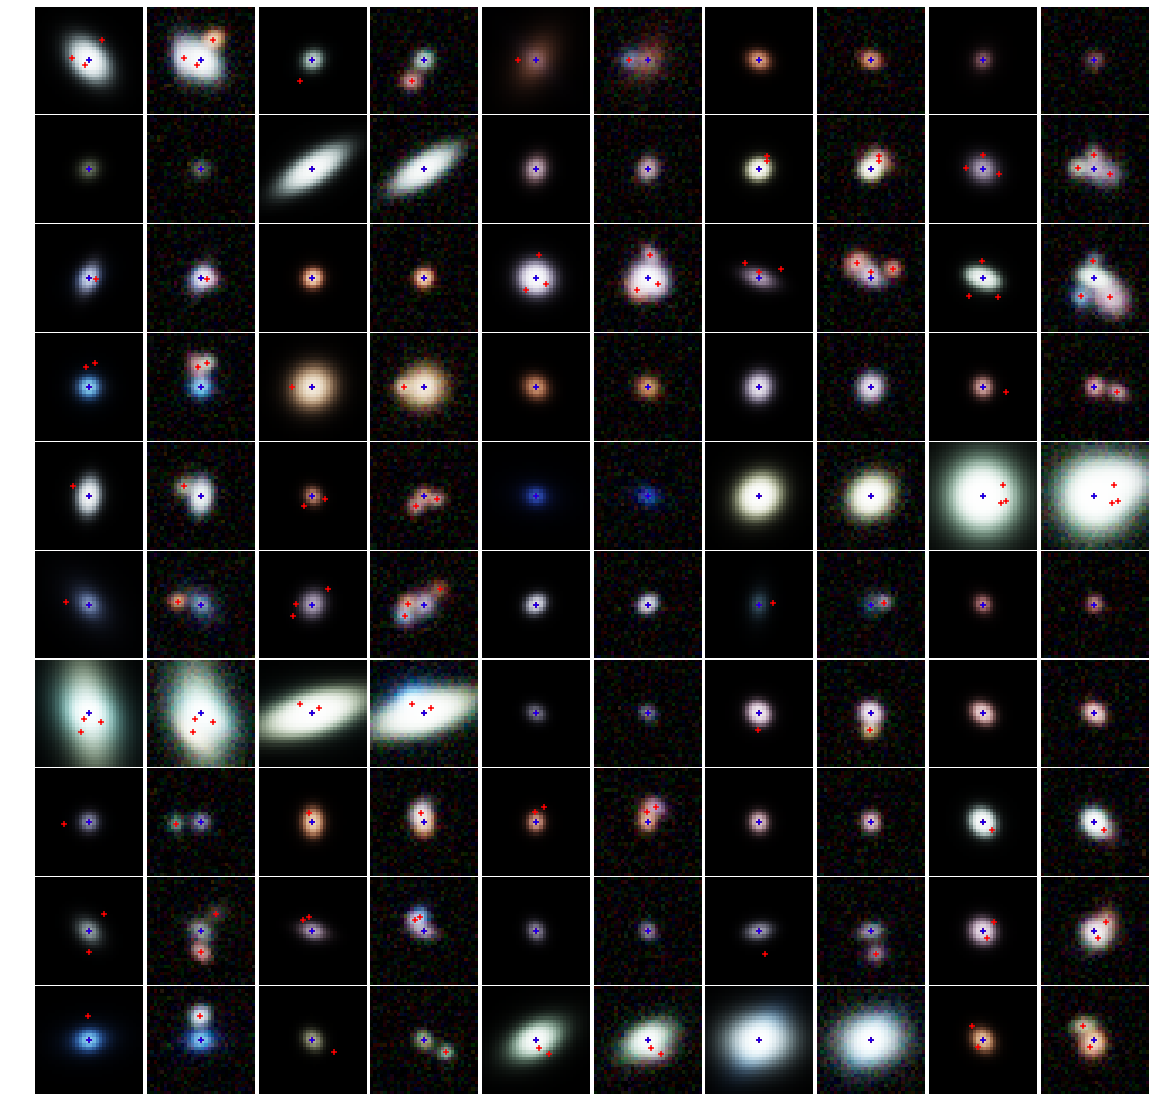

In [22]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [23]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_0.1/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_0.1/test/galaxies_blended_20191024_0_shifts.npy')

input_noisy = test[:500,0]
input_noiseless = test[:500,1]

In [24]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

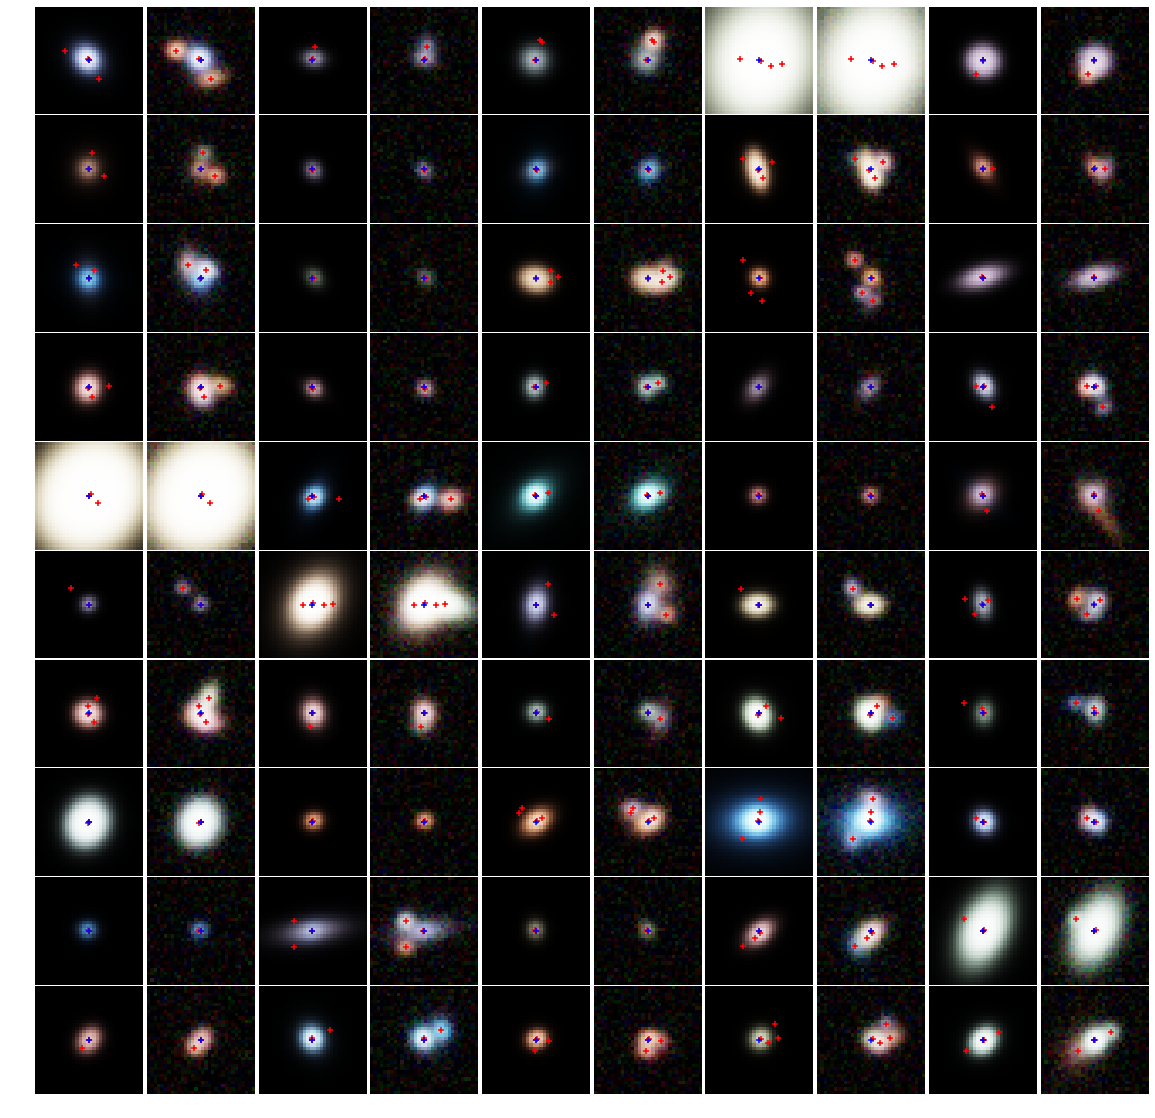

In [25]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [5]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_peak/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_peak/test/galaxies_blended_20191024_0_shifts.npy')

input_noisy = test[:500,0]
input_noiseless = test[:500,1]

In [27]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

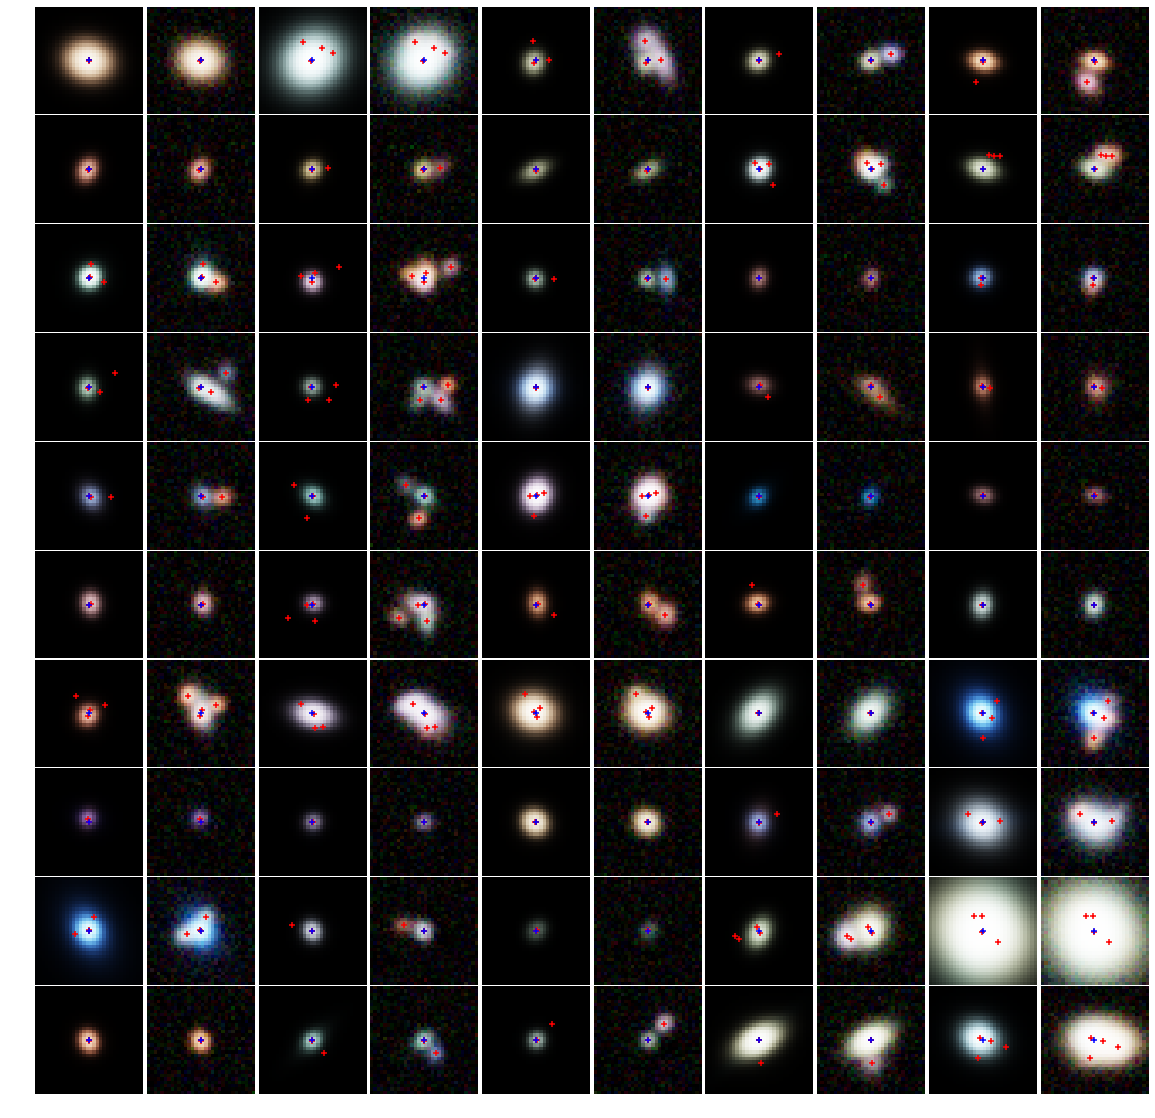

In [28]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [5]:
dfs = []

dfs.append(pd.read_csv('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_peak/test/galaxies_blended_20191024_0_data.csv'))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [125]:
df

nb_blended_gal          SNR  SNR_peak  redshift  moment_sigma        e1  \
0                  1   111.866362  0.086780    0.7766      1.765306  0.171835   
1                  2    59.591072  0.044665    2.7777      1.794781 -0.486423   
2                  1   125.994075  0.065310    1.0716      2.601351  0.498386   
3                  2    62.309926  0.044270    1.9829      1.968783 -0.037474   
4                  3   839.415153  0.350563    0.5754      3.635762 -0.407969   
5                  1   217.676764  0.133675    0.3177      2.455449  0.440349   
6                  4    53.885843  0.043763    0.5017      1.656286  0.108547   
7                  2    82.444650  0.064418    0.6689      1.708514 -0.172781   
8                  4    55.433371  0.038979    0.9777      1.935996  0.142376   
9                  2    33.388812  0.025264    1.1651      1.822097 -0.107931   
10                 3  1669.980672  0.635744    0.1730      5.219133  0.037665   
11                 2    77.548975  0.063372    0.1896      1.698201  0.050823   
12                 3   279.824220  0.263449    0.2600      1.572332 -0.020979   
13                 4   136.568524  0.091873    0.3415      2.037143  0.467837   
14                 2   426.819496  0.316666    0.3263      2.019291 -0.035018   
15                 1    46.981117  0.036442    1.3939      1.683649 -0.568656   
16                 3    75.712442  0.057636    1.1177      1.713003  0.088437   
17                 1    70.033535  0.056435    0.6521      1.657642  0.280032   
18                 2    38.802623  0.029447    3.3151      1.808149 -0.895538   
19                 4   543.217028  0.403220    0.4249      2.076225 -0.450720   
20                 4   134.886774  0.081008    1.1761      2.324770 -0.229494   
21                 2    59.965825  0.052026    0.4715      1.590562 -0.131362   
22                 4   873.093207  0.748563    0.5315      1.838067  0.526988   
23                 4   197.198609  0.142552    0.7159      1.936404 -0.471367   
24                 3    76.548304  0.058603    0.4936      1.771744 -0.382351   
25                 2    65.032026  0.045137    1.1730      2.081316 -0.186165   
26                 2    31.149960  0.021498    1.2162      1.995760  0.357518   
27                 2    58.020757  0.041688    0.8091      2.022403 -0.105428   
28                 1    91.475572  0.071929    2.8125      1.698398 -0.240148   
29                 2    53.035698  0.044389    0.5186      1.577657 -0.017813   
...              ...          ...       ...       ...           ...       ...   
9970               4   216.849326  0.151055    0.3725      2.012882  0.454083   
9971               1   112.025921  0.091342    0.6188      1.770918  0.128623   
9972               4    29.025278  0.022728    0.5689      1.740498 -0.500332   
9973               4    97.755357  0.075660    0.4368      1.734006  0.251412   
9974               3   129.360490  0.105905    0.8339      1.706038  0.331574   
9975               4   258.603961  0.182088    0.8505      2.290709  0.067478   
9976               2    95.090599  0.072710    1.0982      1.885036 -0.382084   
9977               4   154.720980  0.118094    0.5470      1.893634  0.114443   
9978               3   311.432925  0.205919    0.8963      2.166199 -0.025905   
9979               3  1229.332020  0.844864    0.4171      2.641795 -0.423703   
9980               2   194.817321  0.120112    0.0673      2.270418  0.404665   
9981               3  2800.197129  1.760528    0.1701      3.794116 -0.098009   
9982               1   101.965035  0.083828    0.5125      1.698260 -0.376390   
9983               1    42.875876  0.032954    1.2261      1.774592  0.082077   
9984               1    39.881342  0.030239    1.1545      1.799590  0.029387   
9985               2   322.779622  0.148923    0.3990      3.379182  0.042924   
9986               1    46.292399  0.037452    3.6725      1.701003  0.424914   
9987               1    88.180188  0.

#### Cases where closest galaxy to peak is not lowest magnitude

In [9]:
len(np.where(df['idx_closest_to_peak']!= 0)[0])

1472

In [96]:
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_peak/test/galaxies_blended_20191024_0_shifts.npy')

In [14]:
shifts.shape

(10000, 4, 2)

In [23]:
distances = np.empty([len(np.where(df['idx_closest_to_peak']!= 0)[0]),4])

for i, idx in enumerate (np.where(df['idx_closest_to_peak']!= 0)[0]):
    print(idx)
    z = df['idx_closest_to_peak'][idx]
    for k in range (4):
        if k != z:
            print(i,k)
            distances[i,k] = np.sqrt((shifts[idx][z][0]-shifts[idx][k][0])**2+(shifts[idx][z][1]-shifts[idx][k][1])**2)

(1472, 4)
6
0 0
0 2
0 3
20
1 0
1 2
1 3
21
2 0
2 2
2 3
24
3 0
3 2
3 3
26
4 0
4 2
4 3
29
5 0
5 2
5 3
32
6 0
6 2
6 3
33
7 0
7 2
7 3
40
8 0
8 2
8 3
55
9 0
9 1
9 3
60
10 0
10 1
10 3
62
11 0
11 1
11 2
66
12 0
12 1
12 2
68
13 0
13 1
13 3
72
14 0
14 2
14 3
73
15 0
15 2
15 3
76
16 0
16 2
16 3
77
17 0
17 1
17 3
82
18 0
18 2
18 3
86
19 0
19 1
19 2
96
20 0
20 2
20 3
103
21 0
21 2
21 3
120
22 0
22 2
22 3
123
23 0
23 2
23 3
129
24 0
24 2
24 3
130
25 0
25 1
25 3
136
26 0
26 1
26 2
138
27 0
27 2
27 3
144
28 0
28 2
28 3
148
29 0
29 1
29 3
156
30 0
30 2
30 3
158
31 0
31 1
31 3
163
32 0
32 1
32 2
168
33 0
33 2
33 3
176
34 0
34 2
34 3
197
35 0
35 2
35 3
207
36 0
36 1
36 3
216
37 0
37 1
37 3
217
38 0
38 1
38 3
237
39 0
39 2
39 3
239
40 0
40 1
40 3
241
41 0
41 2
41 3
244
42 0
42 2
42 3
252
43 0
43 1
43 2
253
44 0
44 1
44 3
261
45 0
45 1
45 3
267
46 0
46 2
46 3
288
47 0
47 2
47 3
293
48 0
48 2
48 3
300
49 0
49 1
49 3
311
50 0
50 2
50 3
316
51 0
51 2
51 3
333
52 0
52 1
52 3
338
53 0
53 2
53 3
346
54 0
54 2
54

554 3
3677
555 0
555 1
555 3
3687
556 0
556 2
556 3
3688
557 0
557 2
557 3
3691
558 0
558 2
558 3
3694
559 0
559 2
559 3
3695
560 0
560 1
560 3
3697
561 0
561 1
561 3
3704
562 0
562 1
562 3
3705
563 0
563 2
563 3
3707
564 0
564 2
564 3
3710
565 0
565 1
565 3
3731
566 0
566 2
566 3
3735
567 0
567 2
567 3
3752
568 0
568 2
568 3
3774
569 0
569 1
569 2
3782
570 0
570 1
570 2
3795
571 0
571 2
571 3
3800
572 0
572 2
572 3
3804
573 0
573 1
573 3
3825
574 0
574 1
574 3
3833
575 0
575 1
575 2
3839
576 0
576 1
576 3
3841
577 0
577 1
577 3
3849
578 0
578 2
578 3
3855
579 0
579 2
579 3
3863
580 0
580 2
580 3
3866
581 0
581 2
581 3
3871
582 0
582 2
582 3
3873
583 0
583 2
583 3
3895
584 0
584 1
584 3
3910
585 0
585 2
585 3
3912
586 0
586 2
586 3
3918
587 0
587 2
587 3
3919
588 0
588 2
588 3
3936
589 0
589 2
589 3
3942
590 0
590 1
590 3
3947
591 0
591 2
591 3
3951
592 0
592 1
592 3
3961
593 0
593 1
593 2
3972
594 0
594 2
594 3
3997
595 0
595 1
595 3
4020
596 0
596 2
596 3
4021
597 0
597 2
597 3
4022


1150 0
1150 1
1150 3
7744
1151 0
1151 1
1151 3
7745
1152 0
1152 2
1152 3
7750
1153 0
1153 2
1153 3
7763
1154 0
1154 1
1154 3
7764
1155 0
1155 1
1155 2
7768
1156 0
1156 1
1156 2
7769
1157 0
1157 2
1157 3
7774
1158 0
1158 2
1158 3
7777
1159 0
1159 1
1159 2
7780
1160 0
1160 2
1160 3
7782
1161 0
1161 1
1161 3
7784
1162 0
1162 2
1162 3
7792
1163 0
1163 2
1163 3
7793
1164 0
1164 1
1164 2
7801
1165 0
1165 2
1165 3
7803
1166 0
1166 1
1166 2
7809
1167 0
1167 1
1167 3
7826
1168 0
1168 2
1168 3
7831
1169 0
1169 1
1169 3
7832
1170 0
1170 2
1170 3
7840
1171 0
1171 1
1171 3
7852
1172 0
1172 1
1172 3
7864
1173 0
1173 1
1173 2
7881
1174 0
1174 1
1174 3
7887
1175 0
1175 1
1175 3
7893
1176 0
1176 1
1176 3
7901
1177 0
1177 2
1177 3
7904
1178 0
1178 1
1178 2
7905
1179 0
1179 1
1179 3
7931
1180 0
1180 2
1180 3
7951
1181 0
1181 2
1181 3
7954
1182 0
1182 1
1182 2
7958
1183 0
1183 2
1183 3
7967
1184 0
1184 2
1184 3
7972
1185 0
1185 2
1185 3
7977
1186 0
1186 1
1186 2
7996
1187 0
1187 1
1187 3
8008
1188 0
1188 

In [42]:
distances = np.empty([len(np.where(df['idx_closest_to_peak']!= 0)[0])])

for i, idx in enumerate (np.where(df['idx_closest_to_peak']!= 0)[0]):
    print(idx)
    distance = 10
    z = df['idx_closest_to_peak'][idx]
    nb_gal = df['nb_blended_gal'][idx]
    for k in range (nb_gal):
        if k != z:
            distance_temp = np.sqrt((shifts[idx][z][0]-shifts[idx][k][0])**2+(shifts[idx][z][1]-shifts[idx][k][1])**2)
            print(distance_temp)
        if distance_temp < distance:
            distance = distance_temp
    distances[i] = distance

6
1.294660695349857
0.833559070649295
1.4771300088310177
20
1.4909343925424299
2.3238271623657996
1.9690926093865657
21
1.1507694128819321
24
0.5440048232594556
0.6587353354475384
26
0.853611534201881
29
1.3438544904953371
32
0.7643365458169383
1.8295418972900297
33
0.43878985119875447
40
1.1578824529514922
55
0.9032837813116156
1.2904779928582937
60
0.7145914525600727
1.1872241308587612
1.6484442899179572
62
0.38584877789602484
1.487048096566014
1.2938509267060545
66
0.5254162106517853
1.8227008932269997
0.7574588927406489
68
0.35706072821134255
1.1748958705824448
1.3586049729647025
72
0.7511053167036265
73
0.7104438724952243
76
0.9454702976187632
1.010122108089572
77
1.2325109299613437
0.9305547002246816
82
0.6358194172674309
86
0.40364213801621085
1.7366807771930475
1.0123837998922751
96
0.828296733891308
1.7102433772943009
103
0.8706318483510874
1.6938376978564058
0.6487491171980035
120
1.3674504769972622
123
0.7656001764934706
0.3273326946097513
129
1.1222813785489942
0.6283169483

3353
1.4673817100446007
1.4679079719241803
2.3244476973776877
3371
1.2360589787910277
3375
1.2618759250692206
1.9893654520845587
0.48171705601095793
3392
0.9909904630120188
0.8318360676771945
1.8775965365752574
3393
1.225870852249681
1.5300765596638635
0.47719610313591604
3396
0.9569403567224818
3397
1.3625842406919686
2.2754136599146335
3402
1.1800969727651962
3412
0.5368165078906407
0.5343601676690012
3423
0.9363248338333117
1.3641777410008395
3434
1.4936118021708888
1.3539254626584314
1.5009372373948082
3442
0.42044699017462644
0.7736399989982786
1.4302401878848112
3443
0.9463645569363361
1.1912015051062765
0.13481761738182507
3445
0.934289296129135
2.0544801876797276
2.2727591228021065
3447
0.33692509982463964
0.5541521523479114
0.8828389337454035
3450
0.3382958510960761
1.438825346833454
0.5729210194228864
3457
1.2720794793488477
3469
1.1651543689935449
2.2217457393200544
3476
1.2825030586750366
0.11692439896900418
3487
1.22910981218356
2.270406470409392
1.8249328378867349
3503
1.

0.5873444441316837
6458
0.9078931525811519
1.5523844221090948
0.4179221287257645
6474
1.3653323615092205
1.299676035255499
0.22091777096454485
6480
0.8438416816559756
6485
1.3751243258570016
1.410419881176249
6502
0.43400890912404433
0.42810680570548676
6505
1.2881448751775304
0.3410103295148809
0.814452743181582
6511
1.367100150403699
1.5183378275534214
6515
0.905906146716968
0.6483912491381639
0.22408120686078917
6522
0.42766943630130483
1.3497213887371786
6530
1.0784090100055794
6533
0.41697916665697726
1.329105436291742
6539
0.35180792123080756
1.2020218533389315
0.2676291058382016
6561
0.3574456692387505
6566
1.4874622103021788
2.008313912387563
2.0776796908179085
6573
1.4094055586923182
2.716582678208003
6580
1.2102648601986086
6583
1.0982264370058348
6593
0.9867912370246786
1.7942293426129332
2.304886998491644
6637
1.4184107766179626
6638
0.6495977400587206
1.858097092759716
6643
0.7930067161627751
1.3498697580137515
6648
0.6313163067154333
0.6693821965336113
6649
1.015491346421

In [27]:
print(distances.shape)

(1472,)


In [35]:
df_plot = df.drop(np.where(df['nb_blended_gal'] == 1)[0])

In [36]:
len(df_plot) 

7457

In [37]:
1472/7457

0.1973984175942068

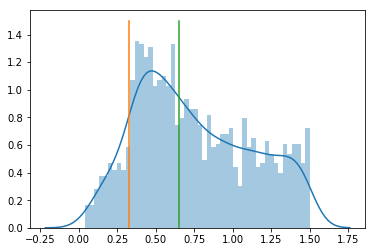

In [68]:
sns.distplot(distances, bins = 50)
plt.plot(0.325*np.ones(1000),np.linspace(0,1.5,1000))
plt.plot(0.65*np.ones(1000),np.linspace(0,1.5,1000))

In [70]:
print(len(np.where(distances < 0.325)[0]))
print(len(np.where(distances < 0.65)[0]))

147
697


In 2% of cases (147/7457) two galaxies centers are within fwhm/2  --> cases to ignore, considered as unrecognized blends (this is 10% of the cases where the lowest magnitude galaxy is not detected as brightest)

In 9% of cases (697/7457) two galaxies centers are within fwhm (this is 47% of the cases where the lowest magnitude galaxy is not detected as brightest)

In [174]:
index = np.where(df['idx_closest_to_peak']!= 0)[0]

In [6]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_peak/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_peak/test/galaxies_blended_20191024_0_shifts.npy')

input_noisy = test[:,0]
input_noiseless = test[:,1]

In [7]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

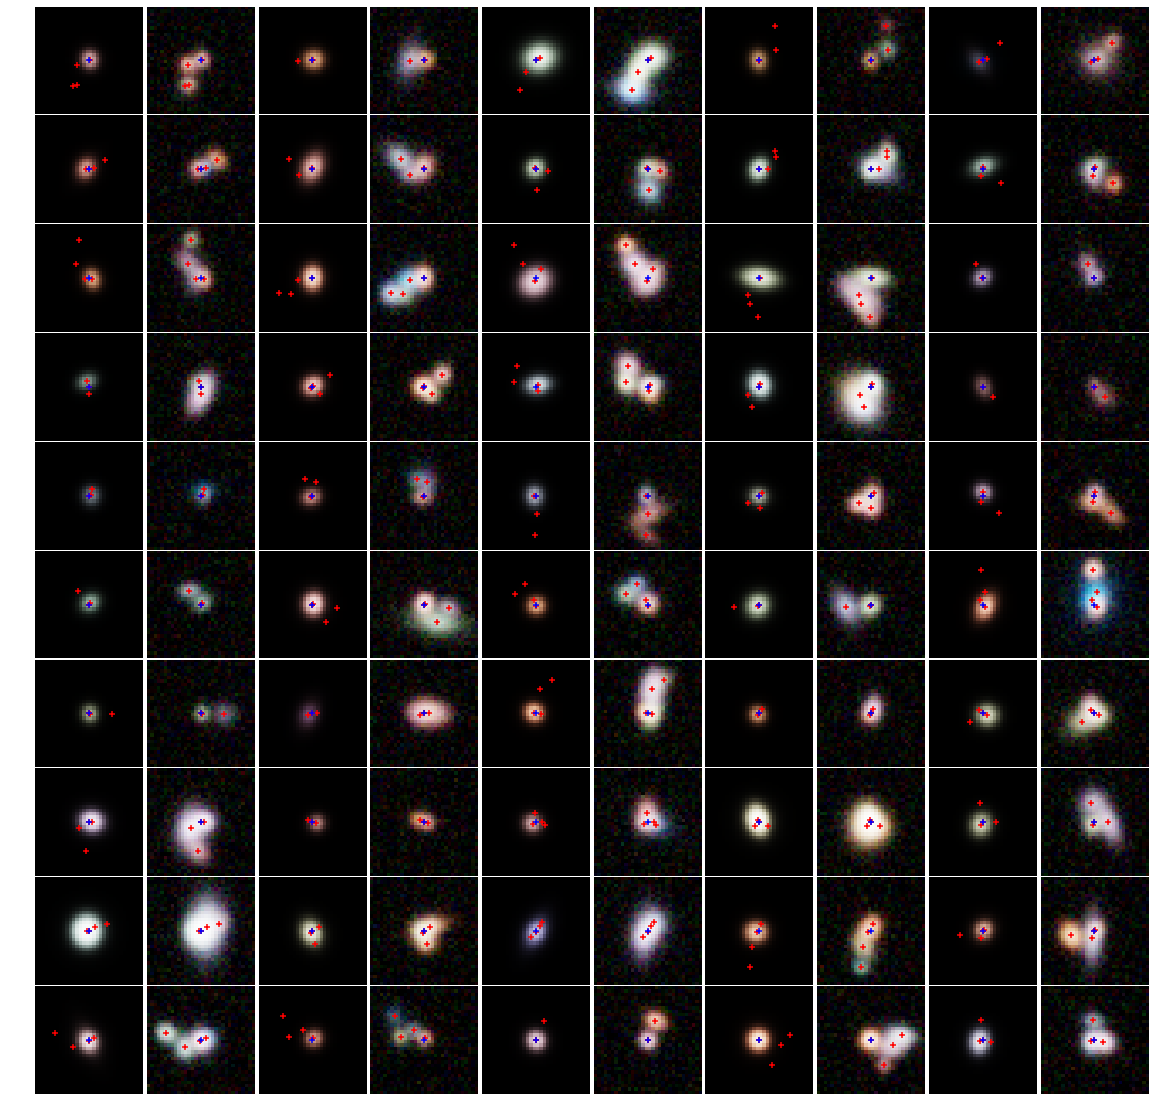

In [61]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(index, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [65]:
index_new = np.delete(index,np.where(distances < 0.65)[0])#325

In [66]:
index_new.shape # = 1472- 147 = 1325 ?

(775,)

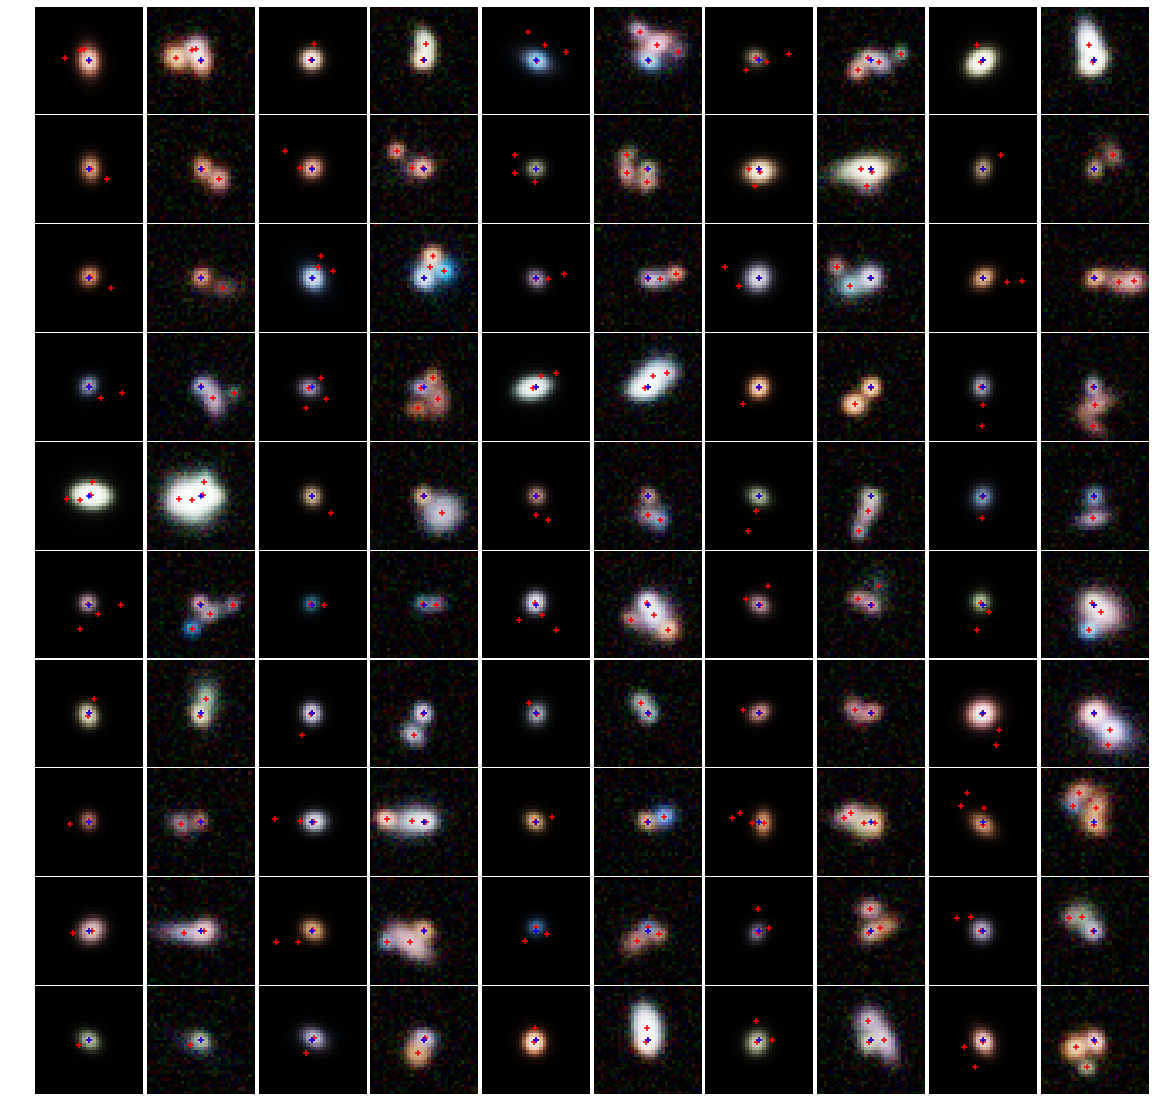

In [67]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(index_new, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

#### Every cases

In [21]:
distances = np.empty([len(np.where(df['nb_blended_gal']!= 1)[0])])



for i, idx in enumerate (np.where(df['nb_blended_gal']!= 1)[0]):
    print(idx)
    distance = 10
    distance_temp = 11
    z = df['idx_closest_to_peak'][idx]
    nb_gal = df['nb_blended_gal'][idx]
    for k in range (nb_gal):
        if k != z:
            distance_temp = np.sqrt((shifts[idx][z][0]-shifts[idx][k][0])**2+(shifts[idx][z][1]-shifts[idx][k][1])**2)
            print(distance_temp)
        if distance_temp < distance:
            distance = distance_temp
    distances[i] = distance

1
0.8920889183128773
3
1.2361753138564462
4
0.4597961737252855
1.472144472126446
6
1.294660695349857
0.833559070649295
1.4771300088310177
7
1.2155964769323129
8
0.9869186077141238
1.1029784526871462
1.0975202892034996
9
0.8753595321197349
10
0.9135163818023444
1.417382188454738
11
1.0164429237836883
12
0.7955248072465425
0.8995739187191679
13
1.2840785857526693
0.9889022197825145
0.9037327355844855
14
1.0798039865496452
16
1.2943467688170094
0.73685057229964
18
0.4551213128784344
19
0.8253300871872115
1.1471993364620012
0.9522308534845124
20
1.4909343925424299
2.3238271623657996
1.9690926093865657
21
1.1507694128819321
22
1.2040832863741746
1.0032854759656342
0.4854396676749307
23
1.0576595273112455
0.466009832001673
1.3288731679531605
24
0.5440048232594556
0.6587353354475384
25
1.2155324221262054
26
0.853611534201881
27
1.144839735813247
29
1.3438544904953371
30
1.4112151158938973
0.9708860475725658
0.8184756480315643
32
0.7643365458169383
1.8295418972900297
33
0.43878985119875447
34


0.44539407231978734
1.135902964831872
0.49499142157542786
826
1.2700572067533482
827
1.1702713556404143
828
0.8268972979500934
829
1.230603775624847
830
1.3377303181941311
832
1.1117049463796311
1.1253741456057875
1.434503320403245
833
1.1106651010770578
1.4991099245163417
834
0.9202534505570009
835
1.203087632302306
0.9079174635502463
0.7521648127450162
836
0.5100723534397679
837
0.36752284604888086
0.9787513658109558
1.3020739993650319
838
1.0939563436219983
1.4580330878015548
1.4072327994948224
840
1.139743969940018
0.9896184793502592
1.393009495298943
841
1.4891515456386153
0.7288915325055808
1.156008225111177
842
1.0903041737250336
1.0166215199447042
843
0.9258135997155038
844
0.7788940972757081
1.293602790972761
845
1.4880004605806587
846
1.4269931948966186
0.47596716219523316
847
0.6545055857514461
0.9303739289950973
1.477259541983888
849
1.3257521539982025
1.4831949806405726
0.7691531149538559
850
0.4813796233894578
1.2852375880000102
851
0.6140446854566031
1.4476932927294583
8

0.9934849543369622
1478
1.2243904627784323
1.4021199800298711
1.1255765286099908
1479
0.9025402380279584
1.1473274907948754
1480
1.073724296502015
1.142638614479987
1481
0.6591352558708167
1.3641420674881932
1482
0.9705214460643568
1.4956515170608093
1483
1.286972327213809
1484
0.821661407723606
1486
1.1603950361208542
1487
1.0782263065148914
2.340041806881269
1488
1.028899491987046
0.5944070663277428
1.1344162630829093
1489
0.6684976395855371
1490
1.3292272136641128
1491
0.6788765449332759
1492
1.0844826080275793
2.0178927331665504
0.21545126552532423
1494
0.8129937773617829
0.8894489280054111
1495
0.9097397449690683
0.5922440180946087
0.8636727663827007
1496
0.9184435814789739
1497
1.3589733883239992
1.1094390792885895
1.167387577087138
1498
1.2698744935474213
1500
1.4936341485937623
0.8965538949494426
0.4721796753218801
1501
1.498989611387821
1503
1.2103375207732618
0.2764087688455069
1.5943775131697675
1504
1.3026988633372962
1.371016752241515
0.7545443362291667
1505
0.868023086918

1.01376598840634
0.6264891803142525
1.3920675350270508
2201
1.2841308691866238
0.997819307885626
1.4748400675789188
2205
0.39847443981739156
1.4310583942229336
1.2404878948937594
2206
0.8518641274598309
2207
0.7930744895268573
2208
1.178002512563559
1.210224020778062
0.8871297482279691
2209
1.0632835071162097
2211
1.4726027641620576
0.8150916899434542
2212
0.8749340650381544
1.3816833829516237
2214
0.9118185231998708
0.574176151600599
2.0982205380194907
2216
1.0401172872025186
1.1391857132517036
2217
1.3792207393187987
0.48468003922115827
2218
1.1606551589253977
0.6183686113266347
2219
1.4779294065971835
0.5105699127455514
0.8941439684730499
2220
0.9991882471974886
1.135294512515006
1.4390870388612649
2221
0.8443485981684773
0.7540225034545728
1.4703608874103018
2222
0.7509737103855518
0.9748930714963834
1.3524805347056126
2223
0.8691357107510665
1.2823182247012557
2224
1.452902214989214
0.9833570762240395
2225
1.270483356769365
2226
1.3781214030069875
1.3981329581350472
2228
0.6511279

1.202080815622381
2885
0.7769873831519226
2886
0.6438576143659139
2887
0.6092658364860954
2888
1.4502008281548138
2889
0.8518831664192436
1.0220627667167093
2890
0.5306991538127092
0.527127501355938
1.4013464602419814
2891
1.3519604022901268
0.8604353977267114
2892
0.6523353821415633
0.6290927349878114
1.2443294973847174
2893
1.2308612137485901
1.1944023349594872
0.44280335272088206
2894
0.6256304361245787
1.4050184211702825
2895
0.9759647492235758
1.0745284326867326
1.1719271252391632
2897
0.9939218097955438
1.220922575724388
0.8169813753923444
2898
1.4669353849405091
2899
0.4351391950908043
1.5953552072849893
2900
1.0406810201810917
1.00872078936787
0.5830265395553991
2902
0.9960114409981377
2903
1.4897592211625863
0.32921877281545575
2904
1.417492236490176
0.9341892544359053
1.398560936954487
2908
1.404228110929721
1.4592301695446777
1.1414010780443697
2910
0.8944430179275185
1.0322791039318784
0.5955127123688493
2911
1.228769854526063
2912
1.2343686463828976
2913
0.8235573073780525

0.6318769208835042
3483
1.164125065531762
1.3027514292350086
1.0883218299038706
3485
1.4165475003462658
0.34226527870805973
1.4494744465145077
3486
1.0093093019283348
1.4821847025980086
3487
1.22910981218356
2.270406470409392
1.8249328378867349
3489
1.434208368279363
0.4511289902708439
1.3496317146164627
3490
0.739854299489966
1.4326446974502953
3492
1.468933732158222
1.1430999241759228
3493
1.3575987844491026
3495
0.8393513076530303
0.4285147590356753
3496
1.3038225680988724
1.460369106773779
0.9623884852991491
3497
1.1543696604028768
3498
0.7519669110065227
0.6863500686503233
0.3686259912163805
3499
1.1434049971015512
3500
0.7664241059970696
3501
0.9651852300702096
0.4428552409652508
1.47425515025805
3502
0.37502815563077957
0.9116267893555593
0.8851662395097426
3503
1.1009532531176875
0.7527214576839872
1.2851408608886323
3504
0.8242827305001369
0.9881994508384185
3506
1.4829009376278588
3508
0.5720378062134532
1.4989129140134039
3509
0.6610981952581472
0.6082579922213495
3512
1.333

1.08871467506463
3966
0.91637339691714
3967
0.601395418213583
3968
0.9825552793762935
1.1610858756233184
3969
1.1161536467189457
1.2827628371608706
1.1742848781627246
3970
1.2916203717888426
1.250128715890427
1.3474999994597694
3971
1.4447690723558853
0.683302672226893
0.5013773330512343
3972
1.3515820056891517
0.7153611269245602
3974
0.8401538422641095
1.3915709314679645
1.048667689709353
3977
0.4359757860216613
1.381451433383791
3978
1.182035321105161
3979
1.4167588739371517
1.2908110618821511
1.360882319150985
3980
1.3347653276371576
3982
1.2601491447802506
0.7460041689327234
3984
1.3700662133847865
3985
1.3956781036156924
1.1232169435012944
1.0237908432162568
3986
1.210195133033284
3987
1.0040534362976883
3989
1.0049997009838478
1.3175781044642347
3990
0.7467727281942617
3991
1.0762069102080771
0.9012501245795183
1.4928264380256282
3992
1.185340050667927
0.571876868921966
3993
1.3473118735948126
1.4854119043429235
3994
1.3791805266846564
0.8770557390696688
3995
1.1740079745031773
1

0.9612391290599052
4812
1.348824584066893
1.1884749167338697
4814
0.791054769895244
4816
1.3362938949167258
4817
1.2166019875009628
1.4768330974614032
1.0964316953298956
4819
1.4548943413873485
1.482168188612388
4821
1.3114105067129442
1.4666394596392274
1.321983100098713
4822
0.9941247536356159
1.480047751266821
4824
0.8373413586119159
1.0240091220316507
1.436512770395113
4825
1.4030470133184896
1.311655319974814
4826
1.4256707850583505
2.6959665695056105
4827
0.6699805656334478
0.6127236248383247
0.9446225526752565
4829
0.9995975601207866
1.7210091282395756
0.4298307977428606
4830
1.0772746935167714
4831
0.8502884433305142
4832
0.8932145227958952
1.3714014588662091
4833
1.3214694632490505
0.3235533531857706
4834
0.34463078190664587
4835
0.7442834934182297
4836
1.344264257697756
4839
0.8002646580619349
1.3965213050955547
4840
1.4788347000456037
4842
1.3554134705581058
1.6624484523415346
2.421180085222677
4844
1.4414246544940277
4845
0.4250000872606047
0.7044296147465363
0.851081552537

5643
0.9864195763545561
0.6182020301021492
1.4330234728321556
5644
1.162140370581994
1.4464018303663218
5645
0.6243756580131414
1.392443078776821
5646
0.5643832583381341
1.1027093249180913
1.8784385057912174
5648
1.415645925147678
0.8754590375908294
5650
1.0510033147076634
1.2031305296422024
1.1338388185286856
5651
0.9148299568812059
1.1842896971959183
0.937185426493221
5652
1.444791420387849
5655
1.2729898542827813
5657
0.8116616768173329
1.3657201759944302
5658
1.1478430085406741
1.0675001539860234
1.0546680313082493
5659
0.7947184699396207
5660
1.0966870104265358
5661
1.299939084600165
1.2258723395297189
5662
1.1032755483988321
1.731361409839823
5663
0.8394674144624416
5664
0.6811608195970018
0.9711404339968853
5665
1.137954654534606
1.3707080484209202
0.6143492886205778
5666
0.6316546539989262
0.5552593709594233
5667
0.649647711244887
1.3916066640312488
5668
0.589895660813105
1.1157393514266012
5669
1.2234344969419713
1.1685661667415748
5670
1.0424748679371896
0.9277011269201744
56

0.7200389463860848
6440
1.2018520248166324
1.3979229487998213
6441
0.94415228652913
1.4974882174302058
6442
1.1392246513404036
0.7607876811889328
1.1155175329231515
6443
1.495442363441432
0.8248847286145099
0.5577475821041201
6444
1.4116114267319575
6446
0.5662762913174888
6448
0.8997819599662904
6449
1.1014454863636904
6451
1.3453486601422187
6452
1.4600466365004712
1.3964946251908874
6453
0.752912969680508
6454
1.2890142961342619
0.5873444441316837
6456
0.4520760068143619
0.8975134974489151
0.7574846407894065
6457
1.2111467565237684
0.86594965073011
6458
0.9078931525811519
1.5523844221090948
0.4179221287257645
6459
0.40113500283474296
1.4201219422170246
6460
0.42869821631555755
1.0485449594298648
6462
1.4040978283076853
6463
1.3559722941029488
1.2041685758045573
6464
1.031350672372743
1.4561736694958511
1.4508633294791113
6465
1.267986254910392
1.4734604229030357
6469
1.4864451079022516
0.5128403900056937
6470
0.3636610005374711
1.3070756227834404
6472
1.4799829837699778
1.2569061041

1.4706592815119914
1.3113160621844147
7280
1.4811173226344247
7281
1.0380782472989316
0.49958691109837344
1.3101454123852072
7282
0.6814308703187115
7283
1.1168149355731916
1.1420559932862613
7284
1.350396789257799
1.3990013676053972
1.2101351489870547
7288
1.3981529558203045
0.871052695245971
7289
0.529446789567612
0.6257229469370412
7290
0.5283025425700839
1.1058632411972007
7292
0.9492803099647145
0.8475675672588218
1.4202873922430048
7293
1.0270762474381656
7295
1.218429027337882
1.1293066267938685
7296
1.1596494904823145
7297
1.0910010107473291
7298
1.4664395121917042
1.4941268686208382
7299
0.8131123625917802
0.8732338700967857
0.7491934178262157
7302
0.5143650036557169
7303
0.4000061446454021
1.1844597144224303
0.4145949231056654
7304
0.8853704947662926
7305
0.6768565267428829
1.9698544079233373
1.175000856589005
7307
1.3542622740023857
7308
1.403028483124945
1.2757626017182906
1.3416420757639624
7310
1.461808198159256
1.0703250033826992
7313
0.9707217185517502
0.550934273464307

0.9936704580689433
1.3654091803441974
1.3836020661009902
8372
0.5217153551396696
1.8000946506339843
8373
0.848268305997778
8374
0.740393386103402
1.0251444836119818
8375
1.0673842347208218
1.4518078831143841
0.9183206158525641
8377
1.2976002502799107
8378
1.3446543917603957
8379
0.6557366025479132
1.5652886396160288
8380
1.4465936949945315
1.394910067783823
8381
0.6941747131252243
8383
1.320082960869405
8384
0.8065088336908851
1.4718949888808595
8385
0.7085346722749006
0.5250490856275296
8387
1.239396687166211
0.7017454783040533
8391
1.3481287202282708
1.1758041597045343
1.1797877077985353
8392
1.280615739100263
8393
0.6343467413400682
1.1057656387407513
1.3197513707847683
8394
1.4184960647161677
0.8359134517519611
8396
1.170402437599809
8397
0.836329556856052
0.7887590362290045
8398
1.0642014885558966
0.7495149121632434
0.38735307666070756
8399
1.3397404258622876
1.2394784145400952
1.1232892496926556
8401
1.205331062765924
8402
0.42095464263988025
1.310708275525356
0.42025997432575896

0.7671072786583335
9179
0.670217412366367
0.7426015309393248
1.3287633192391433
9181
0.4816350595872503
9182
0.9991511656551632
0.6932325503210507
1.456412526208149
9184
0.8498346901368061
1.4497004238616735
9186
1.4389454578478493
9187
0.621324180513593
1.1101343682207432
0.7326350716298652
9188
1.4334940619351697
0.6474519483633319
1.340468111939311
9190
1.2823730374893336
0.3452502057695896
1.6065886435700483
9191
0.6964153931176628
0.546641803233476
9193
0.5806084661553509
9194
1.272326549458569
9195
1.495194501532309
9196
1.4436022236762533
9197
0.9786381290824424
2.1128885488117297
1.6890102289229407
9198
0.528605195540146
0.9849791341264492
9199
0.3969216631502092
0.9825034849965498
0.909491271493899
9200
0.7394816074689652
9201
0.6851232902759066
1.2761312721606293
9202
0.8710351725831036
1.3879068961072378
0.3262117022552219
9203
1.2995090589812033
0.8192486218357766
9205
1.1841027662325458
1.1079931724903804
1.2966710371344423
9207
0.9188515592522756
9208
0.7555993356999454
1

0.4477490563035682
9964
0.6849043309142114
0.8791386548280241
9965
1.4624621202390953
9966
1.4576222332484055
1.4404616100966667
9967
0.3303168465192012
0.4888564074263745
1.0593524241459709
9968
1.056881006005194
0.834238675725685
1.1390356140021438
9969
0.5542408292974016
1.693735883399774
0.9372181474087541
9970
1.379971069500136
1.1128103165711947
1.4354817313500803
9972
0.3748455424374653
1.5469840629288496
0.4806027462427822
9973
1.3445691810750409
1.0556488263769286
1.4105170338722008
9974
0.6854872883234931
1.2288499541931823
9975
0.4961932221776898
1.2960635101327302
1.0402458113130253
9976
0.7029536223316663
9977
0.5471885379139007
0.47189820721880305
1.7474238494862382
9978
1.2944364057300974
0.6757282646237642
9979
0.6047274908478892
1.4605218378744973
9980
1.1681453371986619
9981
0.5826265451669433
0.6682023599869027
9985
1.438397550308915
9988
0.40035191193438724
1.045213665552185
0.6665897909640587
9989
0.6810595616679268
0.3251102962523357
9990
0.33120981251409604
1.077

In [22]:
print(distances.shape)

(7457,)


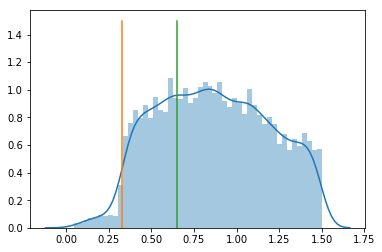

In [23]:
sns.distplot(distances, bins = 50)
plt.plot(0.325*np.ones(1000),np.linspace(0,1.5,1000))
plt.plot(0.65*np.ones(1000),np.linspace(0,1.5,1000))

In [24]:
len(np.where(df['n_peak_detected']!=df['nb_blended_gal'])[0])

5386

In [25]:
where_unrecognized = np.where(df['n_peak_detected']!=df['nb_blended_gal'])[0]

In [26]:
np.where(df['n_peak_detected']!=df['nb_blended_gal'])[0]

array([   1,    4,    6, ..., 9995, 9998, 9999])

In [27]:
indices_test = []
for i, idx in enumerate (np.where(distances < 0.325)[0]):
    indices_test.append(np.where(df['nb_blended_gal']!=1)[0][idx])
indices_test = np.array(indices_test)

In [28]:
indices_test

array([ 129,  163,  217,  293,  429,  451,  533,  552,  581,  677,  725,
        744,  805,  818,  875,  896,  998, 1031, 1039, 1185, 1200, 1202,
       1213, 1283, 1295, 1300, 1320, 1351, 1390, 1463, 1492, 1503, 1550,
       1628, 1781, 1818, 1930, 1960, 1975, 2057, 2147, 2263, 2436, 2597,
       2723, 2808, 2852, 2878, 2947, 2948, 2989, 3034, 3066, 3078, 3091,
       3159, 3209, 3279, 3308, 3316, 3338, 3443, 3476, 3593, 3675, 3800,
       3841, 3866, 4130, 4199, 4213, 4256, 4275, 4277, 4438, 4545, 4594,
       4674, 4833, 4905, 4947, 4954, 5215, 5503, 5537, 5678, 5701, 5730,
       5742, 5785, 5920, 6009, 6055, 6062, 6081, 6166, 6209, 6274, 6306,
       6334, 6341, 6349, 6365, 6376, 6474, 6515, 6539, 6696, 6702, 6910,
       6917, 7008, 7087, 7198, 7205, 7223, 7361, 7668, 7769, 7774, 7904,
       7905, 7996, 8090, 8261, 8436, 8532, 8566, 8851, 8907, 8909, 8917,
       8977, 8992, 9002, 9058, 9085, 9166, 9289, 9424, 9471, 9473, 9602,
       9650, 9728, 9856, 9881])

In [29]:
np.where(where_unrecognized == 9058)[0]

array([], dtype=int64)

In [30]:
len(indices_test)

147

In [59]:
count = 0
index_other = []
index_unrecognized = []
for i, idx in enumerate (indices_test):
    if np.where(where_unrecognized==idx)[0] != False:
        count +=1
        index_unrecognized.append(idx)
    else:
        index_other.append(idx)
        print(idx)
print('total = '+str(count))
index_other = np.array(index_other)

818
1039
1213
1295
3476
3593
4275
4277
6702
9002
9058
total = 136


In [32]:
print(len(np.where(distances < 0.325)[0]))
print(len(np.where(distances < 0.65)[0]))

147
2225


In 2% of cases (147/7457) two galaxies centers are within fwhm/2 . This cases all happen when the lowest mag galaxy is not detected as the brightest --> OK
- 136 are considered as unrecognized blends.
- 11 are recognized but particularly difficults

In 30% of cases (697/7457) two galaxies centers are within fwhm

In [33]:
index_prime = np.where(df['nb_blended_gal']!=1)[0]

In [36]:
len(index_other)

11

In [81]:
index_2 = np.delete(index_prime,np.where(distances < 0.325)[0])#325

In [82]:
index_2.shape # = 7457 - 231 = 7226 ?

(7226,)

NameError: name 'index_2' is not defined

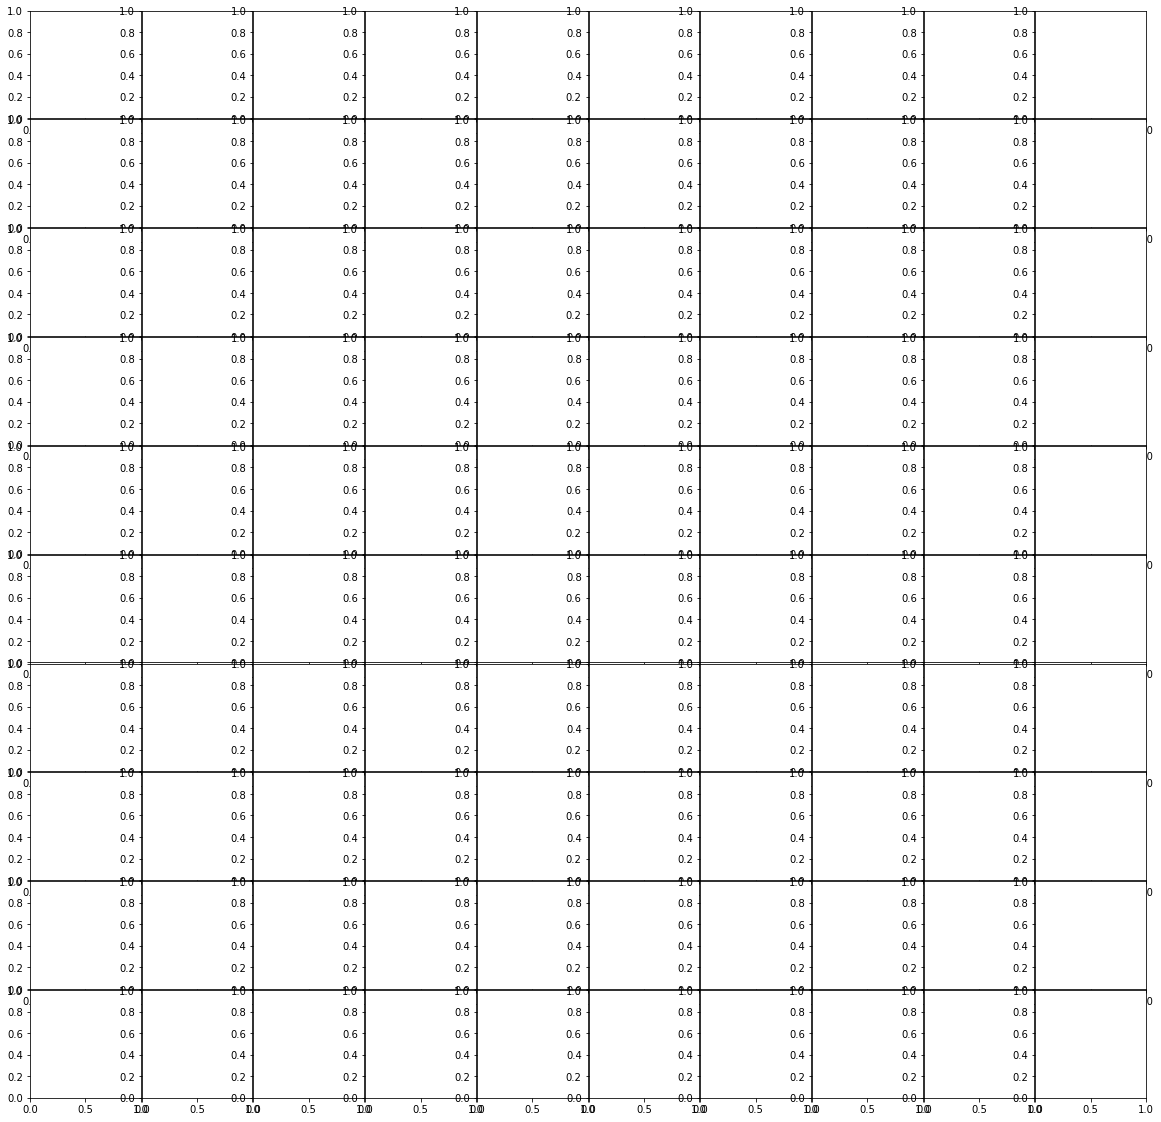

In [56]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(index_2, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

[ 818 1039 1213 1295 3476 3593 4275 4277 6702 9002 9058]


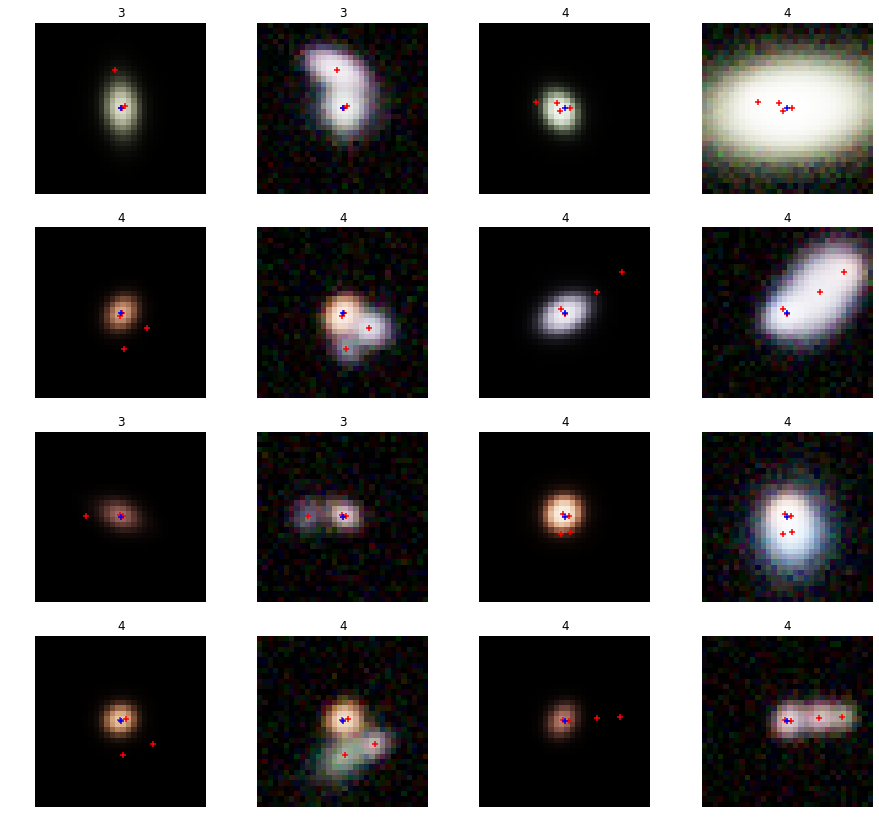

In [58]:
N_plot = 4
fig, axes = plt.subplots(N_plot, N_plot, figsize=(15, 15))
fig.subplots_adjust(wspace=.3, hspace=.01)

indices = index_other#np.random.choice(index_other, size=N_plot*2, replace=False)
print(indices)
for i in range(N_plot):
    k=0
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i*2+k]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i*2+k]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i*2+k]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i*2+k]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')
        axes[i,j].set_title(df['nb_blended_gal'][indices[i*2+k]])
        axes[i,j+1].set_title(df['n_peak_detected'][indices[i*2+k]])
        k+=1

[1463 2597  552 2057 7905 3338 3066 1283 7205 4954 6474 1185 2723 1200
 3866  217 8261 4438 3675 7198 9289 4213 3841 4199 6539 5785 1975 2948
 4256 7996 1960 4674 6365 6515 1930 8907]


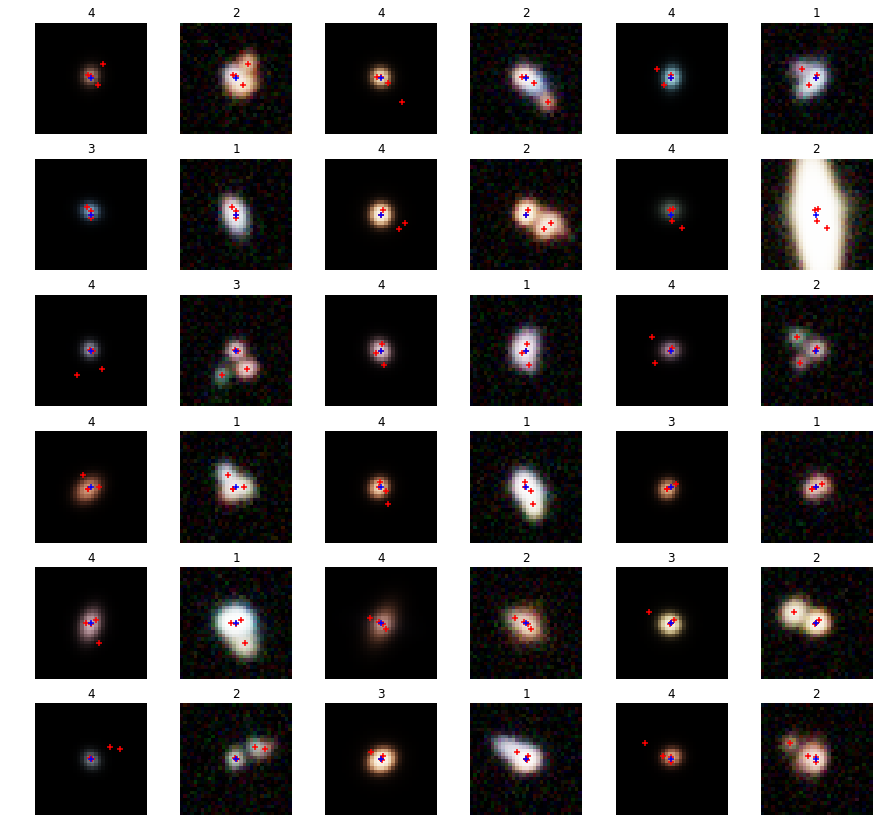

In [62]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(15, 15))
fig.subplots_adjust(wspace=.3, hspace=.01)

indices = np.random.choice(index_unrecognized, size=N_plot*N_plot, replace=False)
print(indices)
for i in range(N_plot):
    k=0
    for j in range(0,N_plot,2):
        plot.plot_rgb(input_noisy[indices[i*N_plot+k]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i*N_plot+k]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i*N_plot+k]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i*N_plot+k]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')
        axes[i,j].set_title(df['nb_blended_gal'][indices[i*N_plot+k]])
        axes[i,j+1].set_title(df['n_peak_detected'][indices[i*N_plot+k]])
        k+=1

#### What about for miscentered_0.1 galaxies ?

In [84]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_0.1/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_0.1/test/galaxies_blended_20191024_0_shifts.npy')

input_noisy = test[:,0]
input_noiseless = test[:,1]

In [85]:
input_noisy = utils.norm(input_noisy, bands,5, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands,5, inplace = False)

In [86]:
dfs = []

dfs.append(pd.read_csv('/sps/lsst/users/barcelin/data/blended_galaxies/miscentered_0.1/test/galaxies_blended_20191024_0_data.csv'))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [87]:
distances = np.empty([len(np.where(df['nb_blended_gal']!= 1)[0])])

for i, idx in enumerate (np.where(df['nb_blended_gal']!= 1)[0]):
    print(idx)
    distance = 10
    z = df['idx_closest_to_peak'][idx]
    nb_gal = df['nb_blended_gal'][idx]
    for k in range (nb_gal):
        if k != z:
            distance_temp = np.sqrt((shifts[idx][z][0]-shifts[idx][k][0])**2+(shifts[idx][z][1]-shifts[idx][k][1])**2)
            print(distance_temp)
        if distance_temp < distance:
            distance = distance_temp
    distances[i] = distance

0
0.3474966475517661
1
0.40245038368462216
1.3324418931709407
1.0054190283383766
2
0.7267257420186705
1.0849042874856467
0.42167224465909414
3
1.2134928439459969
1.1262538506345796
5
0.8371187002778808
6
0.7447456579554522
8
1.3360536814067754
0.5739554541505207
9
1.0080802542150509
0.9580269705113146
10
0.5585949803110978
11
1.20025152011338
0.38764611409950467
1.1864781709408387
12
1.402453376795576
13
1.1638860162857536
1.238724570873701
14
0.5915998988778658
1.0769892460940644
0.941581648618617
15
1.4636973819648815
1.0849546412355457
16
1.156749014955228
17
1.4105613914072979
18
0.4046858043355099
1.4769840365131974
1.4598480780151943
19
0.6135245721788277
20
0.7086769577742122
21
1.4618838002196992
0.5560588849035624
1.2831675350598901
22
1.3046603361342028
23
1.0458140575677357
24
0.47795822105305913
1.1566963204218133
1.0828205235232378
28
1.255101340111499
1.2709443323329486
0.6418726612382779
29
0.6641197778544516
30
1.3044213455708447
31
1.3934619534514538
0.7093709907871247

0.9633126979608609
1.0028948542022227
753
1.318064170581908
1.1873411124270985
1.4616386597069708
754
1.3992890096234338
755
1.3897599686331334
1.3493167105409263
1.3329658331320111
756
1.3936072041207257
1.0516557336059282
0.7065722037651364
757
1.1445764868382933
758
0.7979139256607418
0.4542808935138893
760
0.46568528509623425
761
0.7973764237244512
0.6380379968593618
1.3701460517817179
762
1.0957400850644199
1.2870190640270744
765
1.2248523192659808
0.6911254383663652
766
1.2227697396015857
0.9249398421797735
0.8551348903893161
767
0.8049351813064577
0.406112985850931
768
0.8400019453593894
1.123804380310404
769
1.3505454263024446
0.6831732394689469
1.0544289464936127
770
1.2439400155715512
1.2685262450159394
773
1.3052481472325743
0.5135909876536827
774
1.3445330491998673
777
1.4179345057643227
778
1.4641515196773711
780
0.9739243871169846
0.4236057060715607
781
0.4485637339483869
1.3416621889336253
782
1.3003876837765316
1.164807861377834
1.1423529396620205
785
0.3616026198926524

1409
1.4339798735016331
1.486085089489985
1410
1.3803504067555032
0.612165654953824
1.3747343607753555
1412
1.4696496266036023
1.2725904511786927
1413
1.1127030033703165
1.1394640173742263
1.0246655476264483
1414
0.8193018811208291
1.1311531092671938
0.6131286548705249
1415
1.0472760708093722
0.9792118909458871
1416
1.0034844429316236
0.7552478560281591
1.1627054584937928
1418
0.5368664356731201
1.0255398848227928
1.0355396494615192
1419
0.7130775972153162
1.113140379726236
1420
0.9266327974755406
1.426045952308889
1.2369608485841352
1421
0.8977700635439982
0.8366914095316423
1.431170678607238
1422
0.9108573683320287
1.257026003039072
1.2542598039909243
1423
1.1753703548208208
0.6761828175301242
1424
0.9033442862186963
0.7238113779626235
1425
0.5102652991075018
0.8221890886248208
0.5945416337814337
1426
0.40446649336747037
1.0263565758538
1427
0.5780109922706095
0.6174162440298724
1.1621515639064537
1429
1.3532579714827409
1431
1.4839264989345595
1.4884361525897782
0.3985281430237081
1

0.47448431823470827
0.3977183393462002
2214
0.5860097171305785
0.36774815585566545
1.0536360019989057
2215
1.3404223248228566
0.45400038359134787
0.8984223162783377
2218
1.1474230879803935
0.9578460818932123
2221
0.6304436227212346
0.7628388650591436
0.39421128339387645
2222
1.1464801677316376
0.9108559390764841
0.744051297647331
2224
1.407141764825451
2225
1.0367993605348256
2226
0.5242968186993833
1.2364265111979713
2227
0.6234042031838107
1.0620104749394397
1.4362326736429998
2228
0.8407451256362248
1.0144668474651177
1.077198363220372
2230
0.6487916052123309
1.2538015839030443
1.156064895377251
2231
1.3537273496865705
2232
1.2996524766621698
1.4983540636006176
1.3614549256309254
2233
0.9071704102554599
1.138543416575953
2234
0.9728251481440274
0.5059151188071198
2235
1.1930830665719303
1.4772095467601793
0.8255643339182587
2236
1.244147418889651
2237
0.7505700519002436
0.891056379888956
0.9269470171572007
2238
1.216489676079275
0.5855773690171153
2239
1.4055448375290358
1.380567093

1.4333511501349927
0.8583196804672342
1.4914404532279555
3016
0.7839203461278785
1.394850430617175
3017
1.1160743041289294
1.2807606257975888
1.3500365166734571
3019
0.34651639567176423
1.2252337402536404
1.2534038540765202
3020
0.7129413293524557
3021
1.099974010517812
1.4024642505076204
1.1679529300326719
3023
1.0976906596381295
0.9079100332717916
1.3193421540219987
3024
0.8575471875232663
0.47023975883394903
1.3351039425591904
3025
0.38262522760061957
1.414158766806717
3026
1.3434181094131326
1.4010874105129774
1.487216774588212
3027
1.3192625195470127
0.6523885869323778
0.6458244712526834
3029
0.476565254271308
1.3391262206170431
1.4962554189089905
3030
0.8689727546307621
0.6457880982960544
1.1963219998262447
3031
1.0590890010160248
0.840444091622508
3033
0.8999068580278604
1.1458950693082586
3034
0.8423082692493645
1.299015076477214
1.2409066540135614
3036
0.9363125852887919
0.9102870904745693
3037
1.305132796459337
0.9315821768007766
1.460791000921478
3039
1.099487123739369
1.495

1.4527897565531518
4036
0.8808743975662594
4037
1.3666656454239317
0.736506187812413
4038
1.4297500136348433
1.0735335015579313
0.5316781898271468
4039
0.6088224677797478
1.4721564070992441
1.3568983512328607
4041
1.379874937573062
1.0924594942339427
0.3821751667194689
4042
1.4574122362771125
4043
1.2745330906760457
0.890852740305101
4044
1.4536508419655316
1.0273004317149421
0.6516060577693166
4045
1.3499110232517662
4046
1.2774139504115252
4047
0.4565651886588492
4048
1.214899855201039
1.0299519557589238
4051
1.4881638109713304
1.434459178740432
1.4687879168918383
4052
1.0560676293781612
4053
0.8247989576414466
0.9103550947829134
4054
1.0671401457022258
0.45016112908101413
0.5945998989000392
4055
1.2346975341640523
1.0920617953915726
1.157987709873737
4056
0.8350181661309499
1.4638191421313147
0.9682784851900009
4057
0.7760479161943783
4058
0.9552219844817824
4060
0.35181347358608744
4064
1.2313968385426475
4067
1.1638711237864967
1.1469716341110336
4068
0.9102192509309586
1.10202244

1.209908590116638
0.8014012545691587
1.235464305341093
5169
1.394607038970522
1.2811623059394426
0.9350229423918527
5170
1.357531187849686
5171
1.0770941128832463
5172
0.7621446843924816
5173
1.1186032218343196
0.7593661471410107
1.3182530182868184
5174
0.7141058568283896
5175
1.4074103647922758
0.9376690999205569
5177
0.9133285837611823
0.8457107909432543
0.4082826554611203
5178
1.3808839891947835
5180
0.8449468525241787
1.4380281688709795
5181
1.206506668700856
1.0520973127913182
5182
1.1251743322752894
1.4279467064349187
0.8645679813622742
5183
1.0782543617877165
1.3286440000910544
5184
0.924819241442919
0.5190688609983429
1.2661426025050755
5186
1.2470412352890754
0.709187254678089
1.207720801559992
5187
1.3538413989522426
0.9780428912608434
1.3277158234112099
5188
0.9621215294879641
0.7317771424778157
5189
1.3065072957401207
0.9156173026538722
5190
1.3450451063342985
0.7483115936620021
5192
0.4665736781612975
1.381465317475677
1.228046168935869
5193
1.4730347786068165
0.9654303294

1.2163901964223394
1.263317647643237
1.1370584809361077
6250
0.48826038489134144
6251
1.2994557759214969
6253
1.365191155648749
1.4880662734342847
1.3816806861989575
6254
1.0436706651975505
0.5418182237889786
1.072843087280346
6255
0.7865637111997889
6256
0.9022441426190623
1.18655511826917
0.8423518599029625
6257
1.3587022187975986
0.697264102146487
6258
0.6132312849885458
1.1087896229879957
6259
0.9274370270730864
1.3916490704243154
1.0359636181362961
6260
1.1870311108702154
0.832623033226919
1.1119825357233168
6263
0.7449222753635159
6264
0.6669744018287885
0.7107483025274174
6266
1.0955921704550393
1.3088933863082555
6267
0.7378515384583392
1.0070376349419834
6270
0.7462817579831605
6271
0.8511688145475171
0.8130498429683154
6273
0.39286403505620165
1.2807644133669138
1.019113220807904
6274
1.3217417373191558
6275
0.5237267437567203
1.289226604727367
1.447367955770904
6276
0.8347873701489247
6277
1.341838519077458
1.4304151793977093
6278
0.7806340965640333
0.4344735898174117
6279
1

1.025914848774809
0.5415212131247858
7388
0.8129378816392904
0.6866503603071816
1.4647525531141594
7389
0.9332747631375609
0.8822447927685121
7390
0.8214878854354801
0.918621152021985
1.3454447491080008
7391
1.014792712519339
1.2548397252377506
1.1514056934340051
7392
1.4551223446979777
1.2100221667784028
1.354389653470252
7394
1.426866320266735
1.1388170883914872
1.0736199061817107
7395
1.2894251828980559
0.49062178117558597
1.09083198263097
7396
1.0233278097580647
1.0510365236051258
1.4899564195974226
7397
1.196424922043405
1.2610971548349184
7398
1.0465501705382816
0.47860391044191475
7399
1.2369334320491556
0.6540902934718287
7400
0.7511817208403746
0.7636836748563914
0.821923534252777
7401
1.3973299924701545
7402
1.0790629532327025
1.2954897049540641
1.4458952731004333
7403
1.3592549433775243
0.7310870553951726
7404
1.2870063468598567
0.33039152307406894
7405
0.9290280477440491
7406
0.9226109649052402
0.5958101424217498
0.8064417354956533
7407
0.759736416989674
7409
1.167490624905

0.374232468606434
8493
0.8653236618286482
0.6117125569615608
1.2999557803201396
8495
0.9545048282233952
1.1015698616680283
8496
0.3424855160001275
8497
1.3909410388551167
1.0265901135539686
0.6429534507024708
8498
1.0185928313501147
1.3192741030155373
8501
1.3646885770323207
1.219056973876083
0.46500733029996255
8502
0.7505629684532668
1.1134609692144877
1.2430437994455494
8503
1.3029517831823205
8506
0.9607973797672628
0.6886704183996475
0.8849573431513702
8507
0.9426367699064682
1.419634116513811
8509
0.7951308716748431
1.4360920297776532
8510
0.6018690756361785
8513
1.4784357733996074
8515
0.535000007532215
1.3660063049511981
0.9481481317898852
8516
1.298214978013563
0.5931608018303872
8517
0.4992038882537821
1.3144742171071568
1.0547738653409222
8518
0.6085083748018458
8520
1.3024412413581277
0.5203119419522773
1.1758003171854352
8521
1.133004141188802
0.6977958446532299
0.842412346099255
8522
0.35523850856686995
1.1133620787211835
8523
1.200091257137547
0.40149295977083577
8524
0.

0.9510972782331906
1.0357457090797326
9570
1.4922787143636251
9573
1.2071024607973229
1.482648138415392
0.9776577879500551
9574
1.3179059315454025
1.283487422456545
1.017536955816218
9575
0.988835199353325
0.8516250168504051
9577
1.0333782501738733
0.6563139609087675
9578
1.0269225505938588
9579
0.47960356472905114
1.401472491095781
0.7511650115576743
9580
1.3111277107862593
1.3165309033432235
1.32538736630648
9581
0.6561360630566101
1.1758409298807908
9583
0.835548700115498
0.7224518277335497
9584
1.2077113247051128
1.3736234098879654
1.4882577393666006
9585
0.8085342101361555
9586
0.7050067432507598
0.6141384824653902
9587
1.2231427799949637
0.5549998215920032
9588
1.3729914422035205
0.9965951004099307
9589
1.3000017639032306
9590
0.7368666907310303
1.142147312987972
0.64241009165856
9591
0.9399814398015045
9592
1.063504484466206
0.8004047828962818
1.3641632058218953
9593
0.8001657982540228
1.2287314590534624
9594
1.0105500807475891
1.2278948248375081
9596
0.7927817770742046
9597
1.1

In [88]:
distances.shape

(7508,)

In [90]:
len(np.where(df['idx_closest_to_peak']!=0)[0])

0

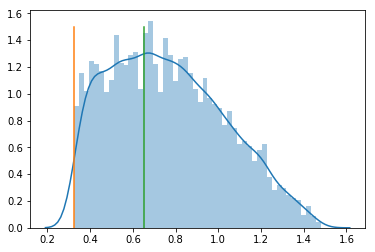

In [89]:
sns.distplot(distances, bins = 50)
plt.plot(0.325*np.ones(1000),np.linspace(0,1.5,1000))
plt.plot(0.65*np.ones(1000),np.linspace(0,1.5,1000))

In [11]:
import tensorflow_probability as tfp
import tensorflow as tf

In [3]:
tfd = tfp.distributions
### Create a mixture of two scalar Gaussians:

In [4]:
gm = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.3, 0.7]),
    components_distribution=tfd.Normal(
      loc=[-1., 1],       # One for each component.
      scale=[0.1, 0.5]))  # And same here.

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(gm.mean().eval())
# ==> 0.4

0.39999998
